# PMT 2 - FIES & LSF

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import os
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from statsmodels.iolib.summary2 import summary_col
import xgboost as xgb




In [2]:
DATA_PATH = '/Users/Ruhama/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Master thesis'

In [3]:
os.makedirs('picture', exist_ok=True)
os.makedirs('output', exist_ok=True)

In [4]:
df_18 = pd.read_csv('output/df_18_ols_occ.csv')

## Regression for weights for PMT

In [5]:
from constants import real_com_ind, real_hh_ind, real_id_ind, label_map


### Check the NANs

In [6]:
nan_counts_df_18 = df_18.isna().sum()
non_zero_nan_counts = nan_counts_df_18[nan_counts_df_18 > 0]

# Filter the non-zero NaN counts to include only variables in hh_ind_real or id_ind_real

filtered_non_zero_nan_counts = []
ind = real_hh_ind + real_id_ind + real_com_ind

for var in ind:
    if var in non_zero_nan_counts.index:
        filtered_non_zero_nan_counts = filtered_non_zero_nan_counts + [var]

nan_counts = df_18[filtered_non_zero_nan_counts].isna().sum()


### Drop the NANs

In [7]:
# Drop rows with NaN values in the specified columns
df_18 = df_18.dropna(subset=real_hh_ind + real_id_ind + real_com_ind + ['PCINC', 'SEQUENCE_NO'])

### Threshold Selection

This section describes how we select the income threshold for poverty classification.

- **Purpose:** The threshold is used to identify the bottom 40% of households by per capita income (PCINC).
- **Method:** We calculate the 40th percentile of PCINC in the dataset. Households with PCINC less than or equal to this value are considered for further analysis.
- **Application:** The threshold is applied separately to both the OLS and XGBoost datasets to filter households for modeling and evaluation.

This approach ensures that our poverty classification focuses on the most vulnerable segment of the population, aligning with policy and research objectives.

In [8]:
# Calculate the 40th percentile value of PCINC for OLS data
threshold = df_18['PCINC'].quantile(0.40)

# Make a copy of the original df_18 for later use (e.g., test set)
df_18_test = df_18.copy()

# Filter df_18 to include only rows with PCINC less than or equal to the 40th percentile threshold
df_18 = df_18[df_18['PCINC'] <= threshold]

# Display the first few rows of the reduced OLS dataframe
# df_18


In [9]:
df_18["w_normalized"] = df_18["RFACT"] / df_18["RFACT"].mean()

### Prep for OLS Regression

In [10]:
df_18 = df_18.reset_index(drop=True)
df_18['log_PCINC'] = np.log(df_18['PCINC'])


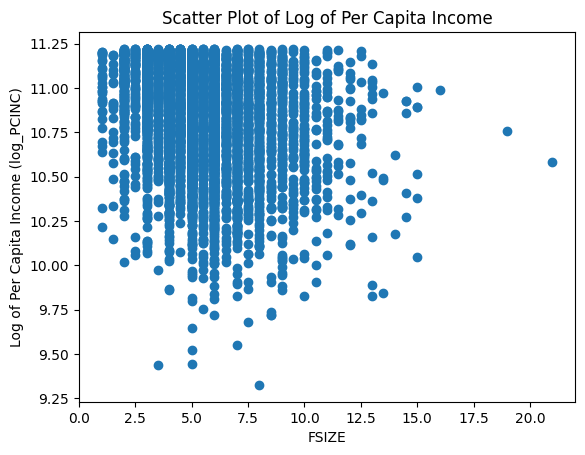

In [11]:
plt.scatter(df_18['FSIZE'], df_18['log_PCINC'])
plt.xlabel('FSIZE')
plt.ylabel('Log of Per Capita Income (log_PCINC)')
plt.title('Scatter Plot of Log of Per Capita Income')
plt.savefig('picture/scatter_fsize_logpcinc_18.png')
plt.show()

### Regression model

In [12]:
#weighted regression
 
  
# --- 1. Choose the dependent variable ---------------------------------------
# The dependent variable for the regression is the log of per capita income.
y = "log_PCINC"  # Column name in df_18


# --- 2. Build the RHS (X) part ----------------------------------------------
# The independent variables (X_terms) are a flat list of household, individual, and community indicators.
# Categorical variables are already wrapped with C() for Patsy, so we leave them as-is.
# Numeric variables are included directly.
X_terms = real_hh_ind + real_id_ind + real_com_ind
rhs = " + ".join(X_terms)  # Example: "C(H150104_TENURE_STA) + H150113_RADIO_QTY + ..."

# --- 3. Stitch the full formula ---------------------------------------------
# Construct the regression formula for Patsy/statsmodels.
formula = f"{y} ~ {rhs}"
print("Formula being sent to Patsy:\n", formula)

# --- 4. Run the model -------------------------------------------------------
# Fit an Ordinary Least Squares (OLS) regression using statsmodels.
# The model estimates the relationship between log_PCINC and the selected predictors.
# 2. Fit a weighted regression and cluster by PSU
model_weighted = smf.wls(formula, data=df_18, weights=df_18["w_normalized"]).fit(
   cov_type='HC1'
)

print(model_weighted.summary())

Formula being sent to Patsy:
 log_PCINC ~ H150104_TENURE_STA + H150113_RADIO_QTY + H150114_TV_QTY + H150115_VCD_QTY + H150116_STEREO_QTY + H150117_REF_QTY + H150118_WASH_QTY + H150119_AIRCON_QTY + H150121_LANDLINE_QTY + H150122_CELL_QTY + H150123_COMP_QTY + H150124_OVEN_QTY + H150120_CAR_QTY + H150125_BANCA_QTY + H150126_MOTOR_QTY + H150102_ROOF + H150103_WALLS + H150101_BLDG_TYPE + H150111_WATER_SUPPLY + H150109_TOILET + H150110_ELECTRICITY + domestic_helper + RPROV + FSIZE + hh_sex + hh_ms + occ4d_1 + occ4d_2 + occ4d_3 + occ4d_4 + occ4d_5 + occ4d_6 + occ4d_7 + occ4d_8 + occ4d_9 + age_0_5 + age_13_17 + age_18_64 + age_65p + age_6_12 + educ_college + educ_none + educ_other + educ_postgrad + educ_primary + educ_secondary + poblacion + street_pattern + acc_nat_hwy + cemetery + city_hall + market + elem_sch + hs_sch + health + hospital + plaza + port + library + waterworks_system + cell_signal + landline + post_office + fire_station
                            WLS Regression Results      

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 102, but rank is 87
  warnings.warn('covariance of constraints does not have full '


In [13]:
with open('output/PMT2_OLS_results_weighted.txt', 'w') as f:
    f.write(model_weighted.summary().as_text())

In [14]:

# --- 1. Choose the dependent variable ---------------------------------------
# The dependent variable for the regression is the log of per capita income.
y = "log_PCINC"  # Column name in df_18

# --- 2. Build the RHS (X) part ----------------------------------------------
# The independent variables (X_terms) are a flat list of household, individual, and community indicators.
# Categorical variables are already wrapped with C() for Patsy, so we leave them as-is.
# Numeric variables are included directly.
X_terms = real_hh_ind + real_id_ind + real_com_ind
rhs = " + ".join(X_terms)  # Example: "C(H150104_TENURE_STA) + H150113_RADIO_QTY + ..."

# --- 3. Stitch the full formula ---------------------------------------------
# Construct the regression formula for Patsy/statsmodels.
formula = f"{y} ~ {rhs}"
print("Formula being sent to Patsy:\n", formula)

# --- 4. Run the model -------------------------------------------------------
# Fit an Ordinary Least Squares (OLS) regression using statsmodels.
# The model estimates the relationship between log_PCINC and the selected predictors.
# 2. Fit a weighted regression and cluster by PSU
model = smf.ols(formula, data=df_18,).fit(
    cov_type='HC1'   # primary sampling unit
)

print(model.summary())

Formula being sent to Patsy:
 log_PCINC ~ H150104_TENURE_STA + H150113_RADIO_QTY + H150114_TV_QTY + H150115_VCD_QTY + H150116_STEREO_QTY + H150117_REF_QTY + H150118_WASH_QTY + H150119_AIRCON_QTY + H150121_LANDLINE_QTY + H150122_CELL_QTY + H150123_COMP_QTY + H150124_OVEN_QTY + H150120_CAR_QTY + H150125_BANCA_QTY + H150126_MOTOR_QTY + H150102_ROOF + H150103_WALLS + H150101_BLDG_TYPE + H150111_WATER_SUPPLY + H150109_TOILET + H150110_ELECTRICITY + domestic_helper + RPROV + FSIZE + hh_sex + hh_ms + occ4d_1 + occ4d_2 + occ4d_3 + occ4d_4 + occ4d_5 + occ4d_6 + occ4d_7 + occ4d_8 + occ4d_9 + age_0_5 + age_13_17 + age_18_64 + age_65p + age_6_12 + educ_college + educ_none + educ_other + educ_postgrad + educ_primary + educ_secondary + poblacion + street_pattern + acc_nat_hwy + cemetery + city_hall + market + elem_sch + hs_sch + health + hospital + plaza + port + library + waterworks_system + cell_signal + landline + post_office + fire_station
                            OLS Regression Results      

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 102, but rank is 87
  warnings.warn('covariance of constraints does not have full '


In [15]:
with open('output/PMT2_OLS_results.txt', 'w') as f:
    f.write(model.summary().as_text())


In [16]:
# Side-by-side economics-style table
table = summary_col(
    [model, model_weighted],
    stars=True,
    float_format='%0.3f',
    model_names=['OLS', 'OLS (Weighted)'],
    info_dict={
        'N': lambda x: f"{int(x.nobs)}",
        'R²': lambda x: f"{x.rsquared:.3f}"
    }
)

with open('output/table_summary.txt', 'w') as f:
    f.write(table.as_text())

## Out of sample testing - FIES 2021

This section is for out-of-sample testing using FIES 2021 data.

- **Purpose:** Evaluate model performance on 2021 data using the same set of household, individual, and community indicators.
- **Variables:** The main variable groups are:
    - `real_hh_ind`: Household asset and housing indicators
    - `real_id_ind`: Individual and demographic indicators
    - `real_com_ind`: Community-level indicators
- **Workflow:** The models trained on 2018 data are applied to 2021 data to assess generalizability and robustness.

Refer to the code cells below for the implementation and results.

In [17]:
poverty_line_2021 = 32977.94

In [18]:

df_21 = pd.read_csv('output/df_21_ols.csv')
df_21_xgb = df_21.copy()
subset = [indicator for indicator in real_hh_ind + real_id_ind + real_com_ind if not indicator.startswith('occ4d_')]
df_21.dropna(subset= subset + ['PCINC', 'RFACT_POP', 'SEQUENCE_NO'], inplace=True)

/var/folders/x5/pd9ssg3n4cd2x2yf5kvq955r0000gp/T/ipykernel_80314/2110333407.py:1: DtypeWarning: Columns (86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_21 = pd.read_csv('output/df_21_ols.csv')


In [19]:
# Calculate the 40th percentile value of PCINC for OLS data
threshold = df_21['PCINC'].quantile(0.40)

# Filter df_21 to include only rows with PCINC less than or equal to the 40th percentile threshold
df_21 = df_21[df_21['PCINC'] <= threshold]

# Display the first few rows of the reduced OLS dataframe
# df_21


In [20]:
df_21["w_normalized"] = df_21["RFACT"] / df_21["RFACT"].mean()

In [21]:
df_21_rest = df_21[
    df_21['H150102_ROOF'].isin(['Others', 'Makeshift/Salvaged/Improvised materials'])
    | df_21['H150103_WALLS'].isin(['Others'])
    | df_21['H150101_BLDG_TYPE'].isin(['Commercial/Industrial/Agricultural building/house'])
    | df_21['H150111_WATER_SUPPLY'].isin(['Other', 'Developed spring'])
    | df_21['H150109_TOILET'].isin(['Public toilet', 'Other'])
].copy()

df_21_ols = df_21[
    ~(
        df_21['H150102_ROOF'].isin(['Others', 'Makeshift/Salvaged/Improvised materials'])
        | df_21['H150103_WALLS'].isin(['Others'])
        | df_21['H150101_BLDG_TYPE'].isin(['Commercial/Industrial/Agricultural building/house'])
         | df_21['H150111_WATER_SUPPLY'].isin(['Other', 'Developed spring'])
        | df_21['H150109_TOILET'].isin(['Public toilet', 'Other'])
    )
].copy()

df_21_ols = df_21_ols.reset_index(drop=True)


In [22]:
# Use the trained OLS model to predict on df_21
sf_21 = model.get_prediction(df_21_ols).summary_frame(alpha=0.05)
df_21_ols["log_PCINC_pred_ols"] = sf_21["mean"]
df_21_ols["log_PCINC_lower_ols"] = sf_21["obs_ci_lower"]

# Back-transform to original scale
df_21_ols["PCINC_pred_ols"] = np.exp(df_21_ols["log_PCINC_pred_ols"])
df_21_ols["PCINC_lower_ols"] = np.exp(df_21_ols["log_PCINC_lower_ols"])

# Display the first few predictions
df_21_ols[["log_PCINC_pred_ols", "PCINC_pred_ols", "log_PCINC_lower_ols", "PCINC_lower_ols"]]

df_21_ols = df_21_ols.rename(columns={
    'PCINC_pred_ols': 'PCINC_PREDICTED_21',
    'PCINC_lower_ols': 'PCINC_LOWER_BOUND_21'
})

df_21_ols['poor_s1'] = (df_21_ols['PCINC_LOWER_BOUND_21'] <= poverty_line_2021).astype(int)

In [23]:
# Use the trained OLS model to predict on df_21
sf_212 = model_weighted.get_prediction(df_21_ols).summary_frame(alpha=0.05)
df_21_ols["log_PCINC_pred_ols_weighted"] = sf_212["mean"]
df_21_ols["log_PCINC_lower_ols_weighted"] = sf_212["obs_ci_lower"]

# Back-transform to original scale
df_21_ols["PCINC_pred_ols_weighted"] = np.exp(df_21_ols["log_PCINC_pred_ols_weighted"])
df_21_ols["PCINC_lower_ols_weighted"] = np.exp(df_21_ols["log_PCINC_lower_ols_weighted"])

# Display the first few predictions
df_21_ols[["log_PCINC_pred_ols_weighted", "PCINC_pred_ols_weighted",
           "log_PCINC_lower_ols_weighted", "PCINC_lower_ols_weighted"]]

df_21_ols = df_21_ols.rename(columns={
    'PCINC_pred_ols_weighted': 'PCINC_PREDICTED_21_weighted',
    'PCINC_lower_ols_weighted': 'PCINC_LOWER_BOUND_21_weighted'
})

df_21_ols['poor_s1_weighted'] = (df_21_ols['PCINC_LOWER_BOUND_21_weighted'] <= poverty_line_2021).astype(int)

In [24]:
nans = df_21_ols[df_21_ols['log_PCINC_pred_ols'].isna()]

In [25]:
df_21_ols[['poor_s1','poor_s1_weighted']].value_counts()

poor_s1  poor_s1_weighted
0        0                   5151
1        1                   1305
0        1                    310
1        0                     32
Name: count, dtype: int64

## In sample - FIES 2018

This section documents the in-sample evaluation for FIES 2018.

- **Dataset:** `df_18` contains household, individual, and community variables for 2018.
- **Variable Groups:**
    - `real_hh_ind`: Household asset and housing indicators (23 variables)
    - `real_id_ind`: Individual and demographic indicators (23 variables)
    - `real_com_ind`: Community-level indicators (16 variables)
- **Missing Data:** All variables in these groups have no missing values after cleaning (`filtered_non_zero_nan_counts` is empty).
- **Analysis:** The in-sample analysis uses these variables to model and predict poverty status, enabling assessment of model fit and error rates on the 2018 data.

Refer to the code cells for details on variable selection, missing data handling, and modeling workflow.

In [26]:
pred = model.get_prediction(df_18)

# Calculate the standard error
sf   = pred.summary_frame(alpha=0.05)    

# back-transform to the original peso scale 
df_18["PCINC_PREDICTED_18"]   = np.exp(sf["mean"])
df_18["PCINC_LOWER_BOUND_18"] = np.exp(sf["obs_ci_lower"])

# Display results
# df_18[['PCINC', 'PCINC_PREDICTED_18', 'PCINC_LOWER_BOUND_18']]

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/_prediction.py:75: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


In [27]:
pred = model_weighted.get_prediction(df_18)
# Calculate the standard error
sf   = pred.summary_frame(alpha=0.05)    

# Back-transform to the original peso scale and create weighted predictions
df_18["PCINC_PREDICTED_18_weighted"] = np.exp(sf["mean"])
df_18["PCINC_LOWER_BOUND_18_weighted"] = np.exp(sf["obs_ci_lower"])

# Display results
# df_18[['PCINC', 'PCINC_PREDICTED_18_weighted', 'PCINC_LOWER_BOUND_18_weighted']]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/_prediction.py:75: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


## Inclusion & exclusion errors

This section documents the calculation and interpretation of inclusion and exclusion errors for poverty prediction models.

- **Inclusion Error:** The proportion of households incorrectly classified as poor (false positives) among all those predicted as poor.
- **Exclusion Error:** The proportion of households incorrectly classified as non-poor (false negatives) among all those truly poor.

These metrics are computed for each model (PMT, Logistic Regression, XGBoost) and for each year (2018, 2021), allowing direct comparison of targeting accuracy.

Refer to the code cells below for the implementation and results.

In [28]:
# Create PMT2 analysis DataFrames for 2018 and 2021 with poverty flags and prediction errors

# For 2018:
# - df_pmt2_18 is a copy of the OLS test set (after exclusions)
# - POOR_PRE_18: predicted poor flag based on lower bound of predicted PCINC vs poverty line
# - POOR_18: actual poor flag based on observed PCINC vs poverty line
# - DF_PREDICTED: difference between actual and predicted PCINC

df_pmt2_18 = df_18.copy()
df_pmt2_18['POOR_PRE_18'] = df_pmt2_18['PCINC_LOWER_BOUND_18'] <= df_pmt2_18['poverty_line']
df_pmt2_18['POOR_18'] = df_pmt2_18['PCINC'] <= df_pmt2_18['poverty_line']
df_pmt2_18['DF_PREDICTED'] = df_pmt2_18['PCINC'] - df_pmt2_18['PCINC_LOWER_BOUND_18']


df_pmt2_18['DF_PREDICTED2'] = df_pmt2_18['PCINC'] - df_pmt2_18['PCINC_PREDICTED_18']

# For 2021:
# - df_pmt2_21 is a copy of the 2021 OLS results
# - POOR_PRE_21: predicted poor flag based on lower bound of predicted PCINC vs poverty line
# - POOR_21: actual poor flag based on observed PCINC vs poverty line
# - DF_PREDICTED: difference between actual and predicted PCINC

df_pmt2_21 = df_21_ols.copy()
df_pmt2_21['POOR_PRE_21'] = df_pmt2_21['PCINC_LOWER_BOUND_21'] <= poverty_line_2021
df_pmt2_21['POOR_21'] = df_pmt2_21['PCINC'] <= poverty_line_2021
df_pmt2_21['DF_PREDICTED'] = df_pmt2_21['PCINC'] - df_pmt2_21['PCINC_LOWER_BOUND_21']



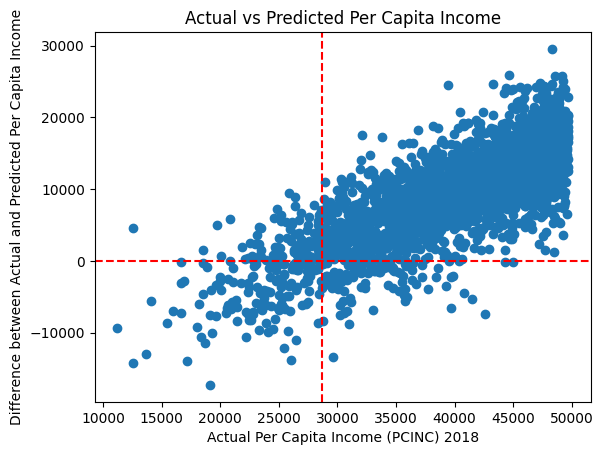

In [29]:
threshold_18 = df_pmt2_18['PCINC'].quantile(0.40)

df_pmt2_18_40 = df_pmt2_18[df_pmt2_18['PCINC'] <= threshold_18]

plt.scatter(df_pmt2_18_40['PCINC'], df_pmt2_18_40['DF_PREDICTED'])
plt.xlabel('Actual Per Capita Income (PCINC) 2018')
plt.ylabel('Difference between Actual and Predicted Per Capita Income')
plt.title('Actual vs Predicted Per Capita Income')
plt.axhline(y=0, color='red', linestyle='--')
plt.axvline(x=28682, color='red', linestyle='--')
plt.savefig('picture/scatter_fsize_logpcinc_18_actual_vs_predicted.png')
plt.show()

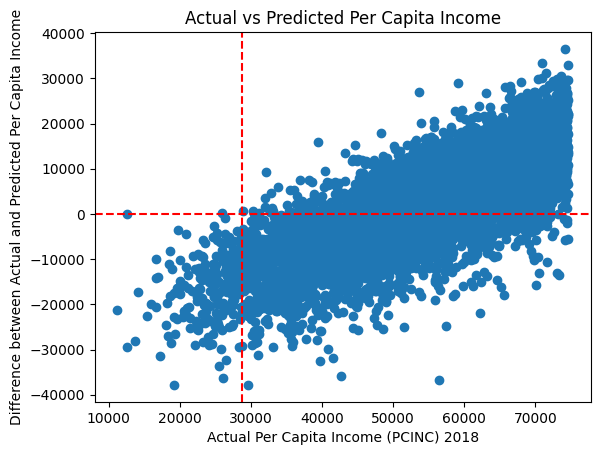

In [30]:


plt.scatter(df_pmt2_18['PCINC'], df_pmt2_18['DF_PREDICTED2'])
plt.xlabel('Actual Per Capita Income (PCINC) 2018')
plt.ylabel('Difference between Actual and Predicted Per Capita Income')
plt.title('Actual vs Predicted Per Capita Income')
plt.axhline(y=0, color='red', linestyle='--')
plt.axvline(x=28682, color='red', linestyle='--')
plt.show()

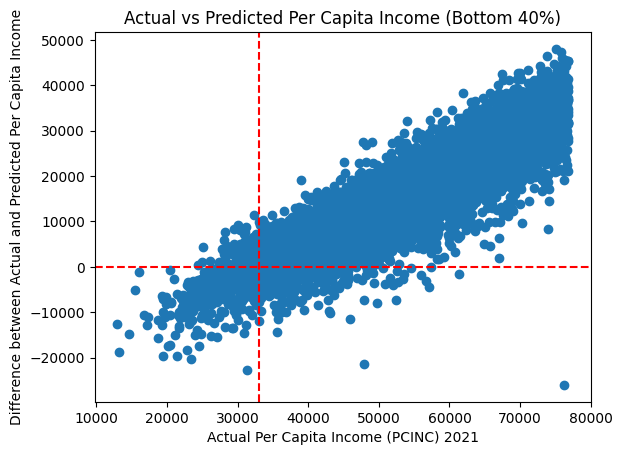

In [31]:


plt.scatter(df_pmt2_21['PCINC'], df_pmt2_21['DF_PREDICTED'])
plt.xlabel('Actual Per Capita Income (PCINC) 2021')
plt.ylabel('Difference between Actual and Predicted Per Capita Income')
plt.title('Actual vs Predicted Per Capita Income (Bottom 40%)')
plt.axhline(y=0, color='red', linestyle='--')
plt.axvline(x=poverty_line_2021, color='red', linestyle='--')
plt.savefig('picture/scatter_fsize_logpcinc_21_actual_vs_predicted.png')
plt.show()

In [32]:
# Confusion matrix components for 2018
TP_18 = ((df_pmt2_18['POOR_PRE_18'] == True) & (df_pmt2_18['POOR_18'] == True)).sum()   # True Positives
FP_18 = ((df_pmt2_18['POOR_PRE_18'] == True) & (df_pmt2_18['POOR_18'] == False)).sum()  # False Positives
FN_18 = ((df_pmt2_18['POOR_PRE_18'] == False) & (df_pmt2_18['POOR_18'] == True)).sum()  # False Negatives
TN_18 = ((df_pmt2_18['POOR_PRE_18'] == False) & (df_pmt2_18['POOR_18'] == False)).sum() # True Negatives

# Compute errors for 2018
exclusion_error_18 = FN_18 / (FN_18 + TP_18) if (FN_18 + TP_18) > 0 else 0
inclusion_error_18 = FP_18 / (FP_18 + TP_18) if (FP_18 + TP_18) > 0 else 0

# Confusion matrix components for 2021
TP_21 = ((df_pmt2_21['POOR_PRE_21'] == True) & (df_pmt2_21['POOR_21'] == True)).sum()   # True Positives
FP_21 = ((df_pmt2_21['POOR_PRE_21'] == True) & (df_pmt2_21['POOR_21'] == False)).sum()  # False Positives
FN_21 = ((df_pmt2_21['POOR_PRE_21'] == False) & (df_pmt2_21['POOR_21'] == True)).sum()  # False Negatives
TN_21 = ((df_pmt2_21['POOR_PRE_21'] == False) & (df_pmt2_21['POOR_21'] == False)).sum() # True Negatives

# Compute errors for 2021
exclusion_error_21 = FN_21 / (FN_21 + TP_21) if (FN_21 + TP_21) > 0 else 0
inclusion_error_21 = FP_21 / (FP_21 + TP_21) if (FP_21 + TP_21) > 0 else 0

# Print results
print("2018:")
print(f"Inclusion Error (False Positives): {inclusion_error_18:.2%}")
print(f"Exclusion Error (False Negatives): {exclusion_error_18:.2%}")

print("\n2021:")
print(f"Inclusion Error (False Positives): {inclusion_error_21:.2%}")
print(f"Exclusion Error (False Negatives): {exclusion_error_21:.2%}")


2018:
Inclusion Error (False Positives): 86.75%
Exclusion Error (False Negatives): 27.88%

2021:
Inclusion Error (False Positives): 81.00%
Exclusion Error (False Negatives): 35.20%


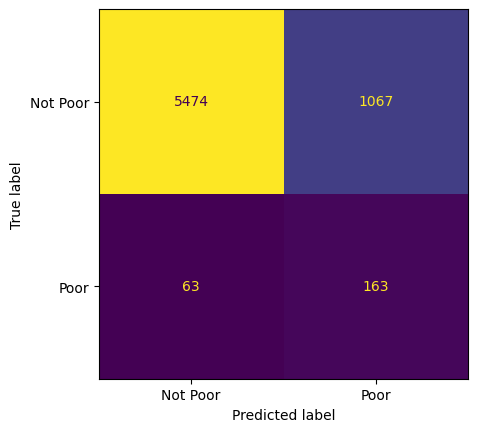

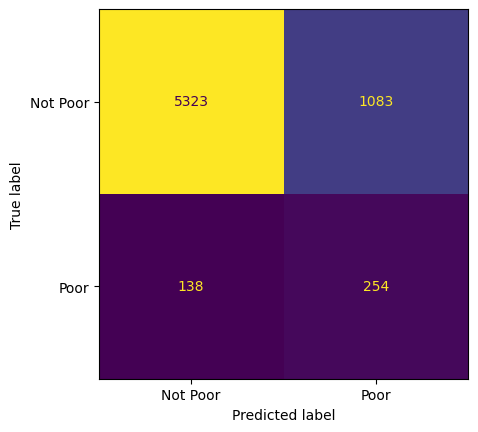

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# For 2018
y_true_18 = df_pmt2_18['POOR_18']
y_pred_18 = df_pmt2_18['POOR_PRE_18']

cm_18 = confusion_matrix(y_true_18, y_pred_18)
disp_18 = ConfusionMatrixDisplay(confusion_matrix=cm_18, display_labels=['Not Poor', 'Poor'])
disp_18.plot(colorbar=False)
plt.savefig('picture/confusion_matrix_l1_2018.png')
plt.show()

# For 2021
y_true_21 = df_pmt2_21['POOR_21']
y_pred_21 = df_pmt2_21['POOR_PRE_21']

cm_21 = confusion_matrix(y_true_21, y_pred_21)
disp_21 = ConfusionMatrixDisplay(confusion_matrix=cm_21, display_labels=['Not Poor', 'Poor'])
disp_21.plot(colorbar=False, values_format='d')
plt.savefig('picture/confusion_matrix_l1_2021.png')
plt.show()

# Beneficaries 

In [34]:
# Create a cross-tabulation of POOR and IND_4PS
comparison_table = pd.crosstab(df_pmt2_18['POOR_18'], df_pmt2_18['IND_4PS'], margins=True)

# Display the comparison table
print(comparison_table)

IND_4PS    No   Yes   All
POOR_18                  
False    5366  1175  6541
True      157    69   226
All      5523  1244  6767


# Second mis classification model

In [35]:
# 0‑1 label for initial poor flag
df_pmt2_18["poor_s1"] = df_pmt2_18["POOR_PRE_18"].astype(int)
# restrict to flagged households + ground‑truth labels
train = df_pmt2_18[df_pmt2_18["poor_s1"] == 1].copy()
train["true_nonpoor"] = (train["PCINC"] > train["poverty_line"]).astype(int)
train["true_poor"] = 1 - train["true_nonpoor"]

# 0‑1 label for initial poor flag
df_pmt2_18["poor_s1_weighted"] = df_pmt2_18["PCINC_LOWER_BOUND_18_weighted"]<=df_pmt2_18["poverty_line"].astype(int)
# restrict to flagged households + ground‑truth labels
train_weighted = df_pmt2_18[df_pmt2_18["poor_s1_weighted"] == 1].copy()
train_weighted["true_nonpoor"] = (train_weighted["PCINC"] > train_weighted["poverty_line"]).astype(int)
train_weighted["true_poor"] = 1 - train_weighted["true_nonpoor"]


In [36]:
cat = [
    "H150104_TENURE_STA", "H150102_ROOF", "H150103_WALLS", "H150101_BLDG_TYPE",
    "H150111_WATER_SUPPLY", "H150109_TOILET", "H150110_ELECTRICITY", "hh_sex", "hh_ms",
]
num = [c for c in X_terms if c not in cat]

pipe1 = make_pipeline(
    make_column_transformer((OneHotEncoder(drop="first", handle_unknown="ignore"), cat), 
                            (StandardScaler(), num)),
    LogisticRegression(solver="saga", max_iter=100_000, n_jobs=-1),
).fit(train[cat + num], train["true_nonpoor"])

train["prob_fp"] = pipe1.predict_proba(train[cat + num])[:, 1]

In [37]:
w = train_weighted['w_normalized']

pipe2 = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(drop="first", handle_unknown="ignore"), cat),
        (StandardScaler(), num)
    ),
    LogisticRegression(
        solver="saga",
        max_iter=100_000,
        n_jobs=-1
    ),
)

pipe2.fit(
    train_weighted[cat + num],
    train_weighted["true_nonpoor"],
    logisticregression__sample_weight=w    
)

train_weighted["prob_fp_w"] = pipe2.predict_proba(train_weighted[cat + num])[:, 1]

In [38]:

train.reset_index( inplace=True)

In [39]:
inc_list, exc_list = [], []
for t in np.arange(0.05, 0.99, 0.01):
    tn, fp, fn, tp = confusion_matrix(
        train["true_poor"], (train["prob_fp"] < t), labels=[0, 1]).astype(int).ravel()
    inc_err = fp / (fp + tp) if (fp + tp) else float('nan')
    exc_err = fn / (fn + tp) if (fn + tp) else float('nan')

    inc_list.append(inc_err)
    exc_list.append(exc_err)
    # print every 10 iteration
    if int(t * 100) % 10 == 0:
        print(f"Threshold: {t:.2f}, Inclusion Error: {inc_err:.2%}, Exclusion Error: {exc_err:.2%}")

Threshold: 0.10, Inclusion Error: 0.00%, Exclusion Error: 98.77%
Threshold: 0.20, Inclusion Error: 0.00%, Exclusion Error: 97.55%
Threshold: 0.30, Inclusion Error: 27.27%, Exclusion Error: 95.09%
Threshold: 0.40, Inclusion Error: 28.57%, Exclusion Error: 90.80%
Threshold: 0.50, Inclusion Error: 34.29%, Exclusion Error: 85.89%
Threshold: 0.60, Inclusion Error: 43.08%, Exclusion Error: 77.30%
Threshold: 0.70, Inclusion Error: 51.80%, Exclusion Error: 58.90%
Threshold: 0.80, Inclusion Error: 61.66%, Exclusion Error: 40.49%
Threshold: 0.90, Inclusion Error: 75.51%, Exclusion Error: 19.02%


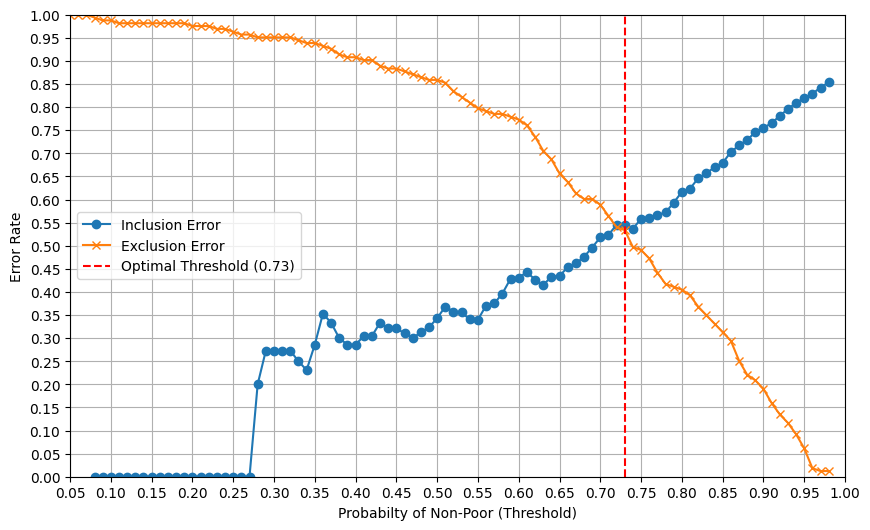

In [40]:
# Plot the inclusion and exclusion errors with respect to the threshold
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.05, 0.99, 0.01), inc_list, label='Inclusion Error', marker='o')
plt.plot(np.arange(0.05, 0.99, 0.01), exc_list, label='Exclusion Error', marker='x')
#plt.title('Inclusion and Exclusion Errors vs. Probabilty of Non-Poor')
plt.xlabel('Probabilty of Non-Poor (Threshold)')
plt.ylabel('Error Rate')
# Add a vertical line at the optimal threshold, which is 0.73
optimal_threshold = 0.73
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Optimal Threshold (0.73)')
plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xlim(0.05, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.savefig('picture/threshold.png', bbox_inches='tight')
plt.show()


In [41]:
thr = 0.73          # or use best_thr from the search above

train['poor_final'] = np.where(
        train['poor_s1'] & (train['prob_fp'] < thr),
        1, 0).astype(int)

Threshold: 0.10, Inclusion Error: 25.00%, Exclusion Error: 98.17%
Threshold: 0.20, Inclusion Error: 12.50%, Exclusion Error: 95.73%
Threshold: 0.30, Inclusion Error: 26.67%, Exclusion Error: 93.29%
Threshold: 0.40, Inclusion Error: 42.86%, Exclusion Error: 90.24%
Threshold: 0.50, Inclusion Error: 47.46%, Exclusion Error: 81.10%
Threshold: 0.60, Inclusion Error: 51.16%, Exclusion Error: 74.39%
Threshold: 0.70, Inclusion Error: 53.33%, Exclusion Error: 57.32%
Threshold: 0.80, Inclusion Error: 63.71%, Exclusion Error: 42.68%
Threshold: 0.90, Inclusion Error: 75.10%, Exclusion Error: 23.78%


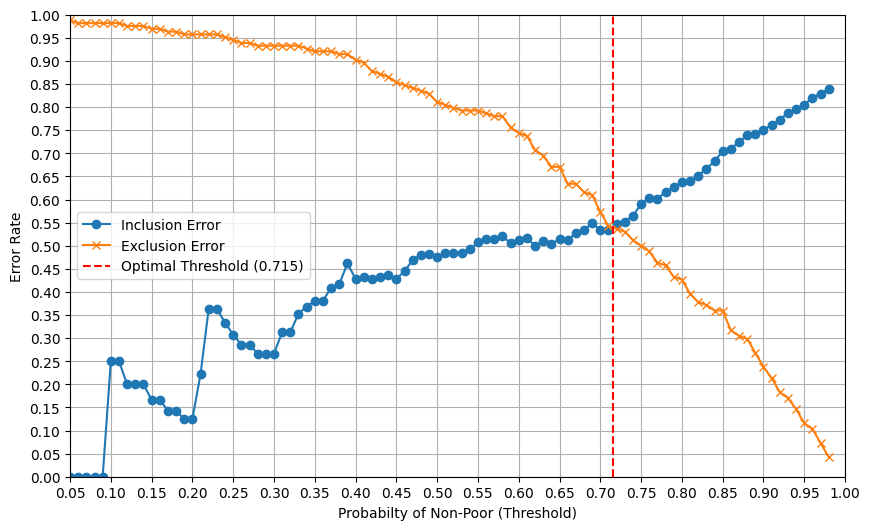

In [42]:
# weighted threshold

inc_list, exc_list = [], []
for t in np.arange(0.05, 0.99, 0.01):
    tn, fp, fn, tp = confusion_matrix(
        train_weighted["true_poor"], (train_weighted["poor_s1"] & (train_weighted["prob_fp_w"] < t)).astype(int)
    ).ravel()
    inc_err, exc_err = fp / (fp + tp) if (fp + tp) else float('nan'), fn / (fn + tp) if (fn + tp) else float('nan')
    inc_list.append(inc_err)
    exc_list.append(exc_err)
    # print every 10 iteration
    if int(t * 100) % 10 == 0:
        print(f"Threshold: {t:.2f}, Inclusion Error: {inc_err:.2%}, Exclusion Error: {exc_err:.2%}")

# Plot the inclusion and exclusion errors with respect to the threshold
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.05, 0.99, 0.01), inc_list, label='Inclusion Error', marker='o')
plt.plot(np.arange(0.05, 0.99, 0.01), exc_list, label='Exclusion Error', marker='x')
#plt.title('Inclusion and Exclusion Errors vs. Probabilty of Non-Poor')
plt.xlabel('Probabilty of Non-Poor (Threshold)')
plt.ylabel('Error Rate')
# Add a vertical line at the optimal threshold, which is 0.715
optimal_threshold_w = 0.715
plt.axvline(optimal_threshold_w, color='red', linestyle='--', label='Optimal Threshold (0.715)')
plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xlim(0.05, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.savefig('picture/threshold_weighted.png', bbox_inches='tight')
plt.show()

thr_w = 0.715          

train_weighted['poor_final_w'] = np.where(
        train_weighted['poor_s1'] & (train_weighted['prob_fp_w'] < thr_w),
        1, 0).astype(int)

In [43]:
# Ensure the indices align between train and df_pmt2_18
df_pmt2_18 = df_pmt2_18.merge(train[['poor_final', 'SEQUENCE_NO']], on='SEQUENCE_NO', how='left')
df_pmt2_18['poor_final'] = df_pmt2_18['poor_final'].fillna(0).astype(int)

# Display the updated dataframe
# df_pmt2_18.head()


In [44]:
# Ensure the indices align between train and df_pmt2_18
df_pmt2_18 = df_pmt2_18.merge(train_weighted[['poor_final_w', 'SEQUENCE_NO']], on='SEQUENCE_NO', how='left')
df_pmt2_18['poor_final_w'] = df_pmt2_18['poor_final_w'].fillna(0).astype(int)

# Display the updated dataframe
# df_pmt2_18.head()

In [45]:
df_pmt2_18['poor_final'].value_counts()

poor_final
0    6600
1     167
Name: count, dtype: int64

In [46]:
tn, fp, fn, tp = confusion_matrix(train['true_poor'],
                                  train['poor_final']).ravel()

inc_err = fp / (fp + tn)
exc_err = fn / (fn + tp)

print(f"Inclusion error 2018: {inc_err:.2%}")
print(f"Exclusion error 2018: {exc_err:.2%}")


Inclusion error 2018: 8.53%
Exclusion error 2018: 53.37%


Inclusion error: 54.49%
Exclusion error: 66.37%


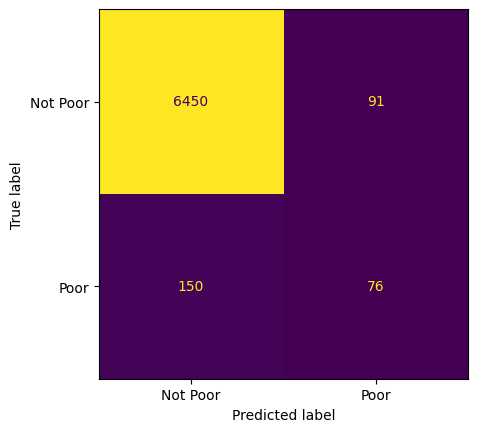

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Calculate inclusion and exclusion errors for 'poor_final' (predict) vs 'POOR_18' (true)
y_true = df_pmt2_18['POOR_18'].astype(bool)
y_pred = df_pmt2_18['poor_final'].astype(bool)

tp = ((y_pred) & (y_true)).sum()
fp = ((y_pred) & (~y_true)).sum()
fn = ((~y_pred) & (y_true)).sum()

inclusion_error = fp / (tp + fp) if (tp + fp) else float('nan')
exclusion_error = fn / (tp + fn) if (tp + fn) else float('nan')

print(f"Inclusion error: {inclusion_error:.2%}")
print(f"Exclusion error: {exclusion_error:.2%}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Poor', 'Poor'])
disp.plot(colorbar=False)
plt.savefig('picture/confusion_matrix_l2_2018.png')
plt.show()


In [48]:
# Apply the trained logistic regression pipeline (pipe) to df_21

# 1. Ensure categorical columns are set to category dtype
cat = [
    "H150104_TENURE_STA", "H150102_ROOF", "H150103_WALLS", "H150101_BLDG_TYPE",
    "H150111_WATER_SUPPLY", "H150109_TOILET", "H150110_ELECTRICITY", "hh_sex", "hh_ms",
]
num = [c for c in X_terms if c not in cat]

df_21_poor = df_21_ols[df_21_ols['poor_s1']==1].copy()

for c in cat:
    df_21_poor[c] = df_21_poor[c].astype("category")

# 2. Predict probability of being a false positive (non-poor)
df_21_poor['prob_false_positive'] = pipe1.predict_proba(df_21_poor[cat + num])[:, 1]

# 3. Apply threshold (e.g., thr1) to flag final poor
df_21_poor['poor_final'] = ((df_21_poor['prob_false_positive'] < thr) & df_21_poor['PCINC_LOWER_BOUND_21'] <= poverty_line_2021).astype(int)

df_pmt2_21 = df_pmt2_21.merge(df_21_poor[['SEQUENCE_NO', 'poor_final']], on='SEQUENCE_NO', how='left')
df_pmt2_21['poor_final'] = df_pmt2_21['poor_final'].fillna(0).astype(int)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [49]:
# Apply the trained logistic regression pipeline (pipe) to df_21 with weighted predictions

df_21_poor_w = df_21_ols[df_21_ols['poor_s1_weighted']==1].copy()

for c in cat:
    df_21_poor_w[c] = df_21_poor_w[c].astype("category")

# 2. Predict probability of being a false positive (non-poor)
df_21_poor_w['prob_false_positive'] = pipe2.predict_proba(df_21_poor_w[cat + num])[:, 1]

# 3. Apply threshold (e.g., thr1) to flag final poor
df_21_poor_w['poor_final_w'] = ((df_21_poor_w['prob_false_positive'] < thr) & df_21_poor_w['PCINC_LOWER_BOUND_21_weighted'] <= poverty_line_2021).astype(int)

df_pmt2_21 = df_pmt2_21.merge(df_21_poor_w[['SEQUENCE_NO', 'poor_final_w']], on='SEQUENCE_NO', how='left')
df_pmt2_21['poor_final_w'] = df_pmt2_21['poor_final_w'].fillna(0).astype(int)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [50]:
df_pmt2_21['poor_s1'].value_counts()

poor_s1
0    5461
1    1337
Name: count, dtype: int64

In [51]:
df_pmt2_21['poor_final'].value_counts()

poor_final
0    5461
1    1337
Name: count, dtype: int64

Inclusion error (2021): 81.00%
Exclusion error (2021): 35.20%


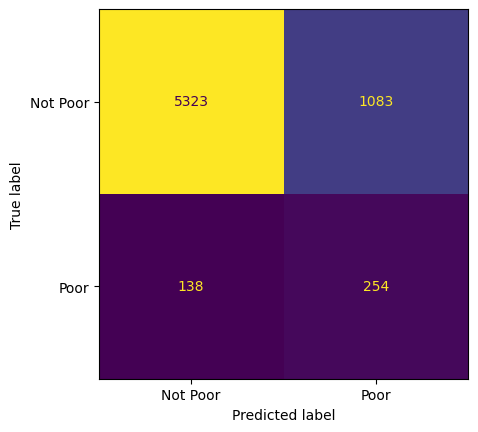

In [52]:
# Calculate inclusion and exclusion errors for 'poor_final' (predict) vs 'POOR_21' (true) in df_21

y_true_21 = (df_pmt2_21['PCINC'] <= poverty_line_2021).astype(bool)
y_pred_21 = df_pmt2_21['poor_final'].astype(bool)

tp_21 = ((y_pred_21) & (y_true_21)).sum()
fp_21 = ((y_pred_21) & (~y_true_21)).sum()
fn_21 = ((~y_pred_21) & (y_true_21)).sum()

inclusion_error_21 = fp_21 / (tp_21 + fp_21) if (tp_21 + fp_21) else float('nan')
exclusion_error_21 = fn_21 / (tp_21 + fn_21) if (tp_21 + fn_21) else float('nan')

print(f"Inclusion error (2021): {inclusion_error_21:.2%}")
print(f"Exclusion error (2021): {exclusion_error_21:.2%}")

# Confusion matrix

cm_21 = confusion_matrix(y_true_21, y_pred_21)
disp_21 = ConfusionMatrixDisplay(confusion_matrix=cm_21, display_labels=['Not Poor', 'Poor'])
disp_21.plot(colorbar=False)
plt.savefig('picture/confusion_matrix_l2_2021.png')
plt.show()

# XGBoost Modeling

This section documents the workflow, parameter tuning, and evaluation for XGBoost models applied to poverty classification and regression.

## Overview

- **Purpose:** Use XGBoost for both regression (predicting log per capita income) and classification (predicting poverty status).
- **Data:** Models are trained on cleaned FIES 2018 data and tested on FIES 2021 and census data.
- **Features:** Household, individual, and community indicators (`real_hh_ind`, `real_id_ind`, `real_com_ind`).

## Workflow

1. **Feature Selection:**  
    - Categorical variables: `cat_vars` (e.g., tenure, roof, walls, sex, marital status).
    - Numeric variables: `num_vars` (all other indicators).
    - All categorical features are cast to `category` dtype for native XGBoost support.

2. **Regression Model:**  
    - Target: `log_PCINC` (log per capita income).
    - Model: `xgb_reg` (`XGBRegressor`).
    - Hyperparameters tuned for RMSE minimization.
    - Evaluation: RMSE and R² on hold-out test set.

3. **Classification Model:**  
    - Target: Binary poverty flag (`PCINC` ≤ poverty line).
    - Model: `xgb_clf` (`XGBClassifier`).
    - Hyperparameters tuned for accuracy and AUC.
    - Evaluation: Confusion matrix, inclusion/exclusion errors, precision-recall curve.

4. **Threshold Optimization:**  
    - Use precision-recall curve to select optimal probability threshold for classification.
    - Apply threshold to generate final poverty predictions.

5. **Out-of-Sample Testing:**  
    - Apply trained models to FIES 2021 and census data.
    - Compare predicted vs. actual poverty status.
    - Compute inclusion and exclusion errors for each year and model.

## Results

- **Parameter Tuning:**  
  Multiple parameter sets tested; best RMSE and classification accuracy reported.
- **Feature Importance:**  
  Top features identified for poverty prediction.
- **Error Metrics:**  
  Inclusion and exclusion errors calculated for all models and years.
- **Visualization:**  
  Confusion matrices and feature importance plots saved for comparison.

## Notes

- All code uses native categorical support in XGBoost (no manual one-hot encoding).
- Data cleaning and feature engineering steps are documented in previous cells.
- Models are compared against baseline regression and logistic regression approaches.




In [53]:
# core scientific stack
import pandas as pd
import numpy as np

# modelling
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# handy if you want to keep using Patsy's formula logic
from patsy import dmatrix


In [54]:
# 1️⃣ Identify exactly which raw columns you want
rhs_vars = real_hh_ind + real_id_ind + real_com_ind
# Make sure none of these strings include "C(" or "["
print([v for v in rhs_vars if "C(" in v or "[" in v])  # should print []

# 2️⃣ Pick out your numeric vs. categorical subsets
# (adjust these lists to match your actual variable names)
cat_vars = [
    'H150104_TENURE_STA','H150102_ROOF','H150103_WALLS',
    'H150101_BLDG_TYPE','H150111_WATER_SUPPLY','H150109_TOILET',
    'H150110_ELECTRICITY','hh_sex','hh_ms'
]
num_vars = [v for v in rhs_vars if v not in cat_vars]

# 3️⃣ Build X directly from df_18 (no dmatrix!)
X = df_18[cat_vars + num_vars].copy()
y = df_18["log_PCINC"]

# 4️⃣ Cast the categoricals
for c in cat_vars:
    X[c] = X[c].astype("category")

# 5️⃣ Sanity-check: there must be no "[" or "]" in the column names
assert not any("[" in col or "]" in col for col in X.columns), \
       "Still see brackets—inadvertent one-hotting is sneaking back in!"

# 6️⃣ Split and fit with native categorical support in XGBoost
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

import xgboost as xgb
from xgboost.callback import EarlyStopping

xgb_reg = xgb.XGBRegressor(
    enable_categorical = True,   # ← key switch
    tree_method        = "hist",
    n_estimators       = 800,
    learning_rate      = 0.05,
    max_depth          = 4,
    subsample          = 0.8,
    colsample_bytree   = 0.8,
    reg_alpha          = 0.1,
    reg_lambda         = 1.0,
    random_state       = 42,
    eval_metric        = "rmse",
    verbosity          = 1
)

xgb_reg.fit(
    X_train, y_train,
    eval_set  = [(X_test, y_test)]
)

# 7️⃣ Evaluate
from sklearn.metrics import mean_squared_error, r2_score
y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Hold-out RMSE: {rmse:.3f}")
print(f"Hold-out R² : {r2_score(y_test, y_pred):.3f}")


[]
[0]	validation_0-rmse:0.27035
[1]	validation_0-rmse:0.26821
[2]	validation_0-rmse:0.26554
[3]	validation_0-rmse:0.26324
[4]	validation_0-rmse:0.26111
[5]	validation_0-rmse:0.25914
[6]	validation_0-rmse:0.25757
[7]	validation_0-rmse:0.25596
[8]	validation_0-rmse:0.25438
[9]	validation_0-rmse:0.25297
[10]	validation_0-rmse:0.25181
[11]	validation_0-rmse:0.25071
[12]	validation_0-rmse:0.24958
[13]	validation_0-rmse:0.24837
[14]	validation_0-rmse:0.24721
[15]	validation_0-rmse:0.24606
[16]	validation_0-rmse:0.24501
[17]	validation_0-rmse:0.24400
[18]	validation_0-rmse:0.24307
[19]	validation_0-rmse:0.24240
[20]	validation_0-rmse:0.24156
[21]	validation_0-rmse:0.24061
[22]	validation_0-rmse:0.23982
[23]	validation_0-rmse:0.23917
[24]	validation_0-rmse:0.23834
[25]	validation_0-rmse:0.23771
[26]	validation_0-rmse:0.23693
[27]	validation_0-rmse:0.23638
[28]	validation_0-rmse:0.23579
[29]	validation_0-rmse:0.23537
[30]	validation_0-rmse:0.23483
[31]	validation_0-rmse:0.23435
[32]	validation

In [55]:
# Predict log_PCINC for df_18 and df_21 using the trained xgb_reg model
# Make sure categorical columns are set to "category" dtype

cat_vars = [
    'H150104_TENURE_STA','H150102_ROOF','H150103_WALLS',
    'H150101_BLDG_TYPE','H150111_WATER_SUPPLY','H150109_TOILET',
    'H150110_ELECTRICITY','hh_sex','hh_ms'
]
num_vars = [v for v in rhs_vars if v not in cat_vars]

for df in [df_18, df_21]:
    for c in cat_vars:
        df[c] = df[c].astype("category")
    X = df[cat_vars + num_vars]
    df["xgb_score"] = xgb_reg.predict(X)
    




In [56]:
# Calculate inclusion and exclusion errors for XGBoost predictions

# For 2018
df_18['pred_poor_xgb'] = df_18['xgb_score'] <= df_18['poverty_line']
y_true_18 = df_18['PCINC'] <= df_18['poverty_line']
y_pred_18 = df_18['pred_poor_xgb'].astype(bool)

tp_18 = ((y_pred_18) & (y_true_18)).sum()
fp_18 = ((y_pred_18) & (~y_true_18)).sum()
fn_18 = ((~y_pred_18) & (y_true_18)).sum()

inclusion_error_18 = fp_18 / (tp_18 + fp_18) if (tp_18 + fp_18) else float('nan')
exclusion_error_18 = fn_18 / (tp_18 + fn_18) if (tp_18 + fn_18) else float('nan')

print(f"2018 XGB Inclusion error: {inclusion_error_18:.2%}")
print(f"2018 XGB Exclusion error: {exclusion_error_18:.2%}")

# For 2021
df_21['pred_poor_xgb'] = df_21['xgb_score'] <= poverty_line_2021
y_true_21 = df_21['PCINC'] <= poverty_line_2021
y_pred_21 = df_21['pred_poor_xgb'].astype(bool)

tp_21 = ((y_pred_21) & (y_true_21)).sum()
fp_21 = ((y_pred_21) & (~y_true_21)).sum()
fn_21 = ((~y_pred_21) & (y_true_21)).sum()

inclusion_error_21 = fp_21 / (tp_21 + fp_21) if (tp_21 + fp_21) else float('nan')
exclusion_error_21 = fn_21 / (tp_21 + fn_21) if (tp_21 + fn_21) else float('nan')

print(f"2021 XGB Inclusion error: {inclusion_error_21:.2%}")
print(f"2021 XGB Exclusion error: {exclusion_error_21:.2%}")

2018 XGB Inclusion error: 96.66%
2018 XGB Exclusion error: 0.00%
2021 XGB Inclusion error: 94.17%
2021 XGB Exclusion error: 0.00%


# XGBoost classifier

In [57]:
import xgboost as xgb
#from xgboost.callback import EarlyStopping
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


In [58]:
# weighted classification with XGBoost
w = df_18['w_normalized']  # use the normalized weights from the OLS model

# 1️⃣ Identify columns
rhs_vars = real_hh_ind + real_id_ind + real_com_ind
print([v for v in rhs_vars if "C(" in v or "[" in v])  # sanity check

# 2️⃣ Set categorical and numeric variables
cat_vars = [
    'H150104_TENURE_STA','H150102_ROOF','H150103_WALLS',
    'H150101_BLDG_TYPE','H150111_WATER_SUPPLY','H150109_TOILET',
    'H150110_ELECTRICITY','hh_sex','hh_ms'
]
num_vars = [v for v in rhs_vars if v not in cat_vars]

# 3️⃣ Build features
X = df_18[cat_vars + num_vars].copy()

# 4️⃣ Construct binary target
y = (df_18['PCINC'] <= df_18['poverty_line']).astype(int)  # 1 = poor, 0 = not poor

# 5️⃣ Cast categoricals
for c in cat_vars:
    X[c] = X[c].astype("category")

# 6️⃣ Ensure no bracket columns
assert not any("[" in col or "]" in col for col in X.columns), \
       "Still see brackets—inadvertent one-hotting is sneaking back in!"

# 7️⃣ Split and train classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, stratify=y, test_size=0.2, random_state=42
)


xgb_clf_w = xgb.XGBClassifier(
    enable_categorical = True,
    tree_method        = "hist",
    n_estimators       = 800,
    learning_rate      = 0.05,
    max_depth          = 4,
    subsample          = 0.8,
    colsample_bytree   = 0.8,
    reg_alpha          = 0.1,
    reg_lambda         = 1.0,
    random_state       = 42,
    eval_metric        = "logloss",
    use_label_encoder  = False,
    verbosity          = 1
)

xgb_clf_w.fit(
    X_train, y_train,
    sample_weight            = w_train, 
    eval_set = [(X_test, y_test)],
    verbose = True
)

# 8️⃣ Evaluate
y_pred_proba = xgb_clf_w.predict_proba(X_test)[:, 1]
y_pred = xgb_clf_w.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("Classification report:\n", classification_report(y_test, y_pred))

[]
[0]	validation_0-logloss:0.14393
[1]	validation_0-logloss:0.14278
[2]	validation_0-logloss:0.14139
[3]	validation_0-logloss:0.14005
[4]	validation_0-logloss:0.13883
[5]	validation_0-logloss:0.13813
[6]	validation_0-logloss:0.13735
[7]	validation_0-logloss:0.13675
[8]	validation_0-logloss:0.13647
[9]	validation_0-logloss:0.13605
[10]	validation_0-logloss:0.13568
[11]	validation_0-logloss:0.13544
[12]	validation_0-logloss:0.13517
[13]	validation_0-logloss:0.13461
[14]	validation_0-logloss:0.13416
[15]	validation_0-logloss:0.13341
[16]	validation_0-logloss:0.13302
[17]	validation_0-logloss:0.13261
[18]	validation_0-logloss:0.13223
[19]	validation_0-logloss:0.13197
[20]	validation_0-logloss:0.13166
[21]	validation_0-logloss:0.13162
[22]	validation_0-logloss:0.13146
[23]	validation_0-logloss:0.13092
[24]	validation_0-logloss:0.13086
[25]	validation_0-logloss:0.13078
[26]	validation_0-logloss:0.13070
[27]	validation_0-logloss:0.13065
[28]	validation_0-logloss:0.13063
[29]	validation_0-log

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:14:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[88]	validation_0-logloss:0.12818
[89]	validation_0-logloss:0.12849
[90]	validation_0-logloss:0.12855
[91]	validation_0-logloss:0.12849
[92]	validation_0-logloss:0.12836
[93]	validation_0-logloss:0.12840
[94]	validation_0-logloss:0.12839
[95]	validation_0-logloss:0.12830
[96]	validation_0-logloss:0.12831
[97]	validation_0-logloss:0.12832
[98]	validation_0-logloss:0.12809
[99]	validation_0-logloss:0.12819
[100]	validation_0-logloss:0.12829
[101]	validation_0-logloss:0.12826
[102]	validation_0-logloss:0.12821
[103]	validation_0-logloss:0.12810
[104]	validation_0-logloss:0.12813
[105]	validation_0-logloss:0.12819
[106]	validation_0-logloss:0.12820
[107]	validation_0-logloss:0.12817
[108]	validation_0-logloss:0.12820
[109]	validation_0-logloss:0.12831
[110]	validation_0-logloss:0.12841
[111]	validation_0-logloss:0.12831
[112]	validation_0-logloss:0.12842
[113]	validation_0-logloss:0.12837
[114]	validation_0-logloss:0.12826
[115]	validation_0-logloss:0.12834
[116]	validation_0-logloss:0.128

In [59]:


# 1️⃣ Identify columns
rhs_vars = real_hh_ind + real_id_ind + real_com_ind
print([v for v in rhs_vars if "C(" in v or "[" in v])  # sanity check

# 2️⃣ Set categorical and numeric variables
cat_vars = [
    'H150104_TENURE_STA','H150102_ROOF','H150103_WALLS',
    'H150101_BLDG_TYPE','H150111_WATER_SUPPLY','H150109_TOILET',
    'H150110_ELECTRICITY','hh_sex','hh_ms'
]
num_vars = [v for v in rhs_vars if v not in cat_vars]

# 3️⃣ Build features
X = df_18[cat_vars + num_vars].copy()

# 4️⃣ Construct binary target
y = (df_18['PCINC'] <= df_18['poverty_line']).astype(int)  # 1 = poor, 0 = not poor

# 5️⃣ Cast categoricals
for c in cat_vars:
    X[c] = X[c].astype("category")

# 6️⃣ Ensure no bracket columns
assert not any("[" in col or "]" in col for col in X.columns), \
       "Still see brackets—inadvertent one-hotting is sneaking back in!"

# 7️⃣ Split and train classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


xgb_clf = xgb.XGBClassifier(
    enable_categorical = True,
    tree_method        = "hist",
    n_estimators       = 800,
    learning_rate      = 0.05,
    max_depth          = 4,
    subsample          = 0.8,
    colsample_bytree   = 0.8,
    reg_alpha          = 0.1,
    reg_lambda         = 1.0,
    random_state       = 42,
    eval_metric        = "logloss",
    use_label_encoder  = False,
    verbosity          = 1
)

xgb_clf.fit(
    X_train, y_train,
    eval_set = [(X_test, y_test)],
    verbose = True
)

# 8️⃣ Evaluate
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
y_pred = xgb_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("Classification report:\n", classification_report(y_test, y_pred))

[]
[0]	validation_0-logloss:0.14420
[1]	validation_0-logloss:0.14294
[2]	validation_0-logloss:0.14113
[3]	validation_0-logloss:0.13990
[4]	validation_0-logloss:0.13906
[5]	validation_0-logloss:0.13808
[6]	validation_0-logloss:0.13741
[7]	validation_0-logloss:0.13640
[8]	validation_0-logloss:0.13614
[9]	validation_0-logloss:0.13551
[10]	validation_0-logloss:0.13492
[11]	validation_0-logloss:0.13415
[12]	validation_0-logloss:0.13353
[13]	validation_0-logloss:0.13289
[14]	validation_0-logloss:0.13177
[15]	validation_0-logloss:0.13061
[16]	validation_0-logloss:0.13034
[17]	validation_0-logloss:0.12988
[18]	validation_0-logloss:0.12944
[19]	validation_0-logloss:0.12927
[20]	validation_0-logloss:0.12898
[21]	validation_0-logloss:0.12851
[22]	validation_0-logloss:0.12824
[23]	validation_0-logloss:0.12730
[24]	validation_0-logloss:0.12675
[25]	validation_0-logloss:0.12630
[26]	validation_0-logloss:0.12641
[27]	validation_0-logloss:0.12615
[28]	validation_0-logloss:0.12602
[29]	validation_0-log

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:14:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[113]	validation_0-logloss:0.12361
[114]	validation_0-logloss:0.12363
[115]	validation_0-logloss:0.12358
[116]	validation_0-logloss:0.12368
[117]	validation_0-logloss:0.12365
[118]	validation_0-logloss:0.12362
[119]	validation_0-logloss:0.12357
[120]	validation_0-logloss:0.12350
[121]	validation_0-logloss:0.12349
[122]	validation_0-logloss:0.12366
[123]	validation_0-logloss:0.12386
[124]	validation_0-logloss:0.12394
[125]	validation_0-logloss:0.12422
[126]	validation_0-logloss:0.12431
[127]	validation_0-logloss:0.12437
[128]	validation_0-logloss:0.12436
[129]	validation_0-logloss:0.12433
[130]	validation_0-logloss:0.12437
[131]	validation_0-logloss:0.12432
[132]	validation_0-logloss:0.12445
[133]	validation_0-logloss:0.12454
[134]	validation_0-logloss:0.12468
[135]	validation_0-logloss:0.12458
[136]	validation_0-logloss:0.12467
[137]	validation_0-logloss:0.12466
[138]	validation_0-logloss:0.12477
[139]	validation_0-logloss:0.12477
[140]	validation_0-logloss:0.12470
[141]	validation_0-l

In [60]:
# Assume xgb_clf is your trained XGBClassifier
# cat_vars and num_vars already defined
# df_18 and df_21 are your datasets

for c in cat_vars:
    cat_type = df_18[c].dtype      
    df_18 = df_18.copy()
    df_21 = df_21.copy()
    df_18[c] = df_18[c].astype(cat_type)
    df_21[c] = df_21[c].astype(cat_type)


for df in [df_21, df_18]:
    # 1. Ensure categorical columns are set correctly
    for c in cat_vars:
        df[c] = df[c].astype("category")

    # 2. Get features
    X = df[cat_vars + num_vars]

    # 3. Predict probability of being poor
    df["xgb_poor_prob"] = xgb_clf.predict_proba(X)[:, 1]
    df["xgb_poor_prob_w"] = xgb_clf_w.predict_proba(X)[:, 1]

In [61]:
y_true = df_18['PCINC'] <= df_18['poverty_line']
y_scores = df_18['xgb_poor_prob']
inc_list, exc_list = [], []
for t in np.arange(0.00, 0.99, 0.01):
    tn, fp, fn, tp = confusion_matrix(
        y_true, (y_scores > t).astype(bool)
    ).ravel()
    inc_err, exc_err = fp / (fp + tp) if (fp + tp) else float('nan'), fn / (fn + tp) if (fn + tp) else float('nan')

    inc_list.append(inc_err)
    exc_list.append(exc_err)
    # print every 10 iteration
    if int(t * 100) % 10 == 0:
        print(f"Threshold: {t:.2f}, Inclusion Error: {inc_err:.2%}, Exclusion Error: {exc_err:.2%}")

Threshold: 0.00, Inclusion Error: 96.66%, Exclusion Error: 0.00%
Threshold: 0.10, Inclusion Error: 41.46%, Exclusion Error: 15.04%
Threshold: 0.20, Inclusion Error: 22.31%, Exclusion Error: 16.81%
Threshold: 0.30, Inclusion Error: 12.26%, Exclusion Error: 17.70%
Threshold: 0.40, Inclusion Error: 7.65%, Exclusion Error: 19.91%
Threshold: 0.50, Inclusion Error: 2.89%, Exclusion Error: 25.66%
Threshold: 0.60, Inclusion Error: 1.97%, Exclusion Error: 34.07%
Threshold: 0.70, Inclusion Error: 1.68%, Exclusion Error: 48.23%
Threshold: 0.80, Inclusion Error: 1.25%, Exclusion Error: 65.04%
Threshold: 0.90, Inclusion Error: 0.00%, Exclusion Error: 88.50%


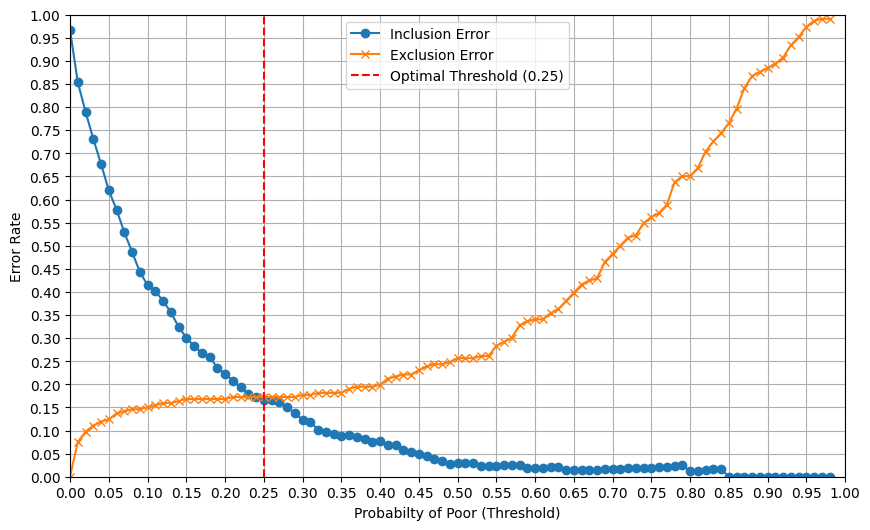

In [62]:
# Plot the inclusion and exclusion errors with respect to the threshold
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.00, 0.99, 0.01), inc_list, label='Inclusion Error', marker='o')
plt.plot(np.arange(0.00, 0.99, 0.01), exc_list, label='Exclusion Error', marker='x')
#plt.title('Inclusion and Exclusion Errors vs. Probabilty of Non-Poor')
plt.xlabel('Probabilty of Poor (Threshold)')
plt.ylabel('Error Rate')
# Add a vertical line at the optimal threshold, which is 0.25
optimal_threshold = 0.25
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Optimal Threshold (0.25)')
plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xlim(0.00, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid()

plt.savefig('picture/xgb_threshold_classification.png', bbox_inches='tight')
plt.show()

Threshold: 0.00, Inclusion Error: 96.66%, Exclusion Error: 0.00%
Threshold: 0.10, Inclusion Error: 47.09%, Exclusion Error: 19.47%
Threshold: 0.20, Inclusion Error: 29.27%, Exclusion Error: 23.01%
Threshold: 0.30, Inclusion Error: 18.63%, Exclusion Error: 26.55%
Threshold: 0.40, Inclusion Error: 9.60%, Exclusion Error: 29.20%
Threshold: 0.50, Inclusion Error: 7.69%, Exclusion Error: 36.28%
Threshold: 0.60, Inclusion Error: 5.84%, Exclusion Error: 42.92%
Threshold: 0.70, Inclusion Error: 2.61%, Exclusion Error: 50.44%
Threshold: 0.80, Inclusion Error: 0.00%, Exclusion Error: 65.93%
Threshold: 0.90, Inclusion Error: 0.00%, Exclusion Error: 82.74%


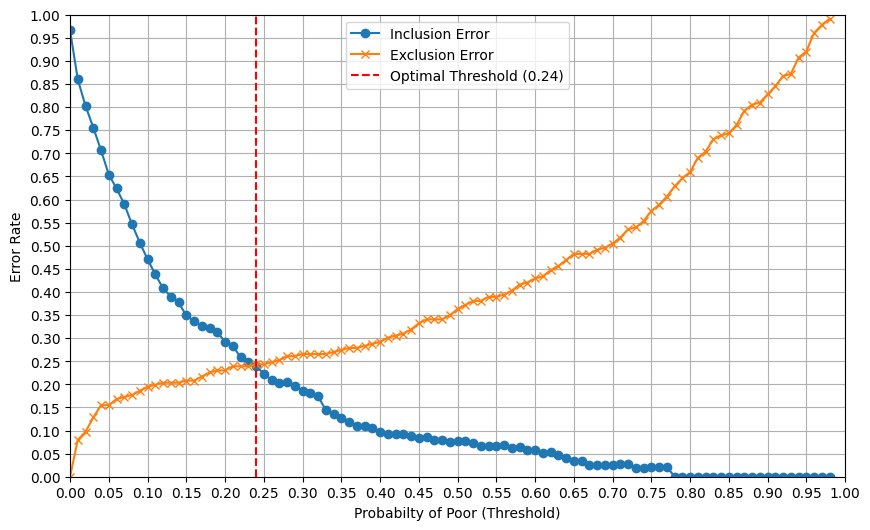

In [63]:
# weighted classification with XGBoost

y_true = df_18['PCINC'] <= df_18['poverty_line']
y_scores = df_18['xgb_poor_prob_w']
inc_list, exc_list = [], []
for t in np.arange(0.00, 0.99, 0.01):
    tn, fp, fn, tp = confusion_matrix(
        y_true, (y_scores > t).astype(bool)
    ).ravel()
    inc_err, exc_err = fp / (fp + tp) if (fp + tp) else float('nan'), fn / (fn + tp) if (fn + tp) else float('nan')

    inc_list.append(inc_err)
    exc_list.append(exc_err)
    # print every 10 iteration
    if int(t * 100) % 10 == 0:
        print(f"Threshold: {t:.2f}, Inclusion Error: {inc_err:.2%}, Exclusion Error: {exc_err:.2%}")


# Plot the inclusion and exclusion errors with respect to the threshold
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.00, 0.99, 0.01), inc_list, label='Inclusion Error', marker='o')
plt.plot(np.arange(0.00, 0.99, 0.01), exc_list, label='Exclusion Error', marker='x')
#plt.title('Inclusion and Exclusion Errors vs. Probabilty of Non-Poor')
plt.xlabel('Probabilty of Poor (Threshold)')
plt.ylabel('Error Rate')
# Add a vertical line at the optimal threshold, which is 0.24
optimal_threshold_w = 0.24
plt.axvline(optimal_threshold_w, color='red', linestyle='--', label='Optimal Threshold (0.24)')
plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xlim(0.00, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid()

plt.savefig('picture/xgb_threshold_weighted_classification.png', bbox_inches='tight')
plt.show()

In [64]:
df_18["xgb_is_poor"] = (df_18["xgb_poor_prob"] > optimal_threshold).astype(int) 
df_21["xgb_is_poor"] = (df_21["xgb_poor_prob"] > optimal_threshold).astype(int) 


In [65]:
df_18["xgb_is_poor_w"] = (df_18["xgb_poor_prob_w"] > optimal_threshold_w).astype(int) 
df_21["xgb_is_poor_w"] = (df_21["xgb_poor_prob_w"] > optimal_threshold_w).astype(int) 


2018 XGB Inclusion error: 16.52%
2018 XGB Exclusion error: 17.26%
2021 XGB Inclusion error: 46.67%
2021 XGB Exclusion error: 96.00%


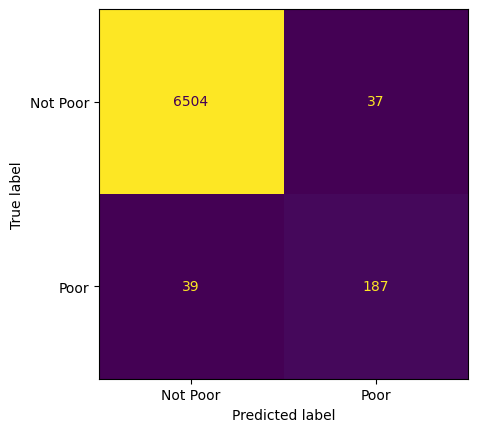

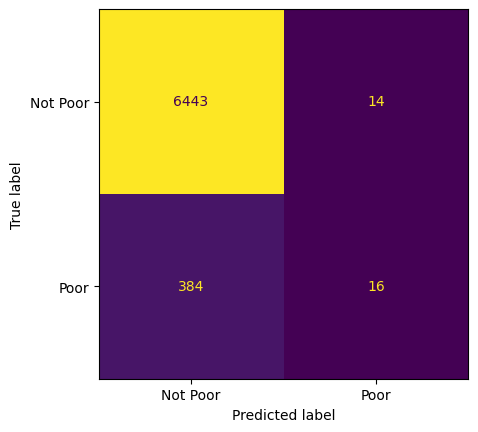

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ---- For 2018 ----
y_true_18 = df_18['PCINC'] <= df_18['poverty_line']
y_pred_18 = df_18['xgb_is_poor'].astype(bool)

tp_18 = ((y_pred_18) & (y_true_18)).sum()
fp_18 = ((y_pred_18) & (~y_true_18)).sum()
fn_18 = ((~y_pred_18) & (y_true_18)).sum()

inclusion_error_18 = fp_18 / (tp_18 + fp_18) if (tp_18 + fp_18) else float('nan')
exclusion_error_18 = fn_18 / (tp_18 + fn_18) if (tp_18 + fn_18) else float('nan')

print(f"2018 XGB Inclusion error: {inclusion_error_18:.2%}")
print(f"2018 XGB Exclusion error: {exclusion_error_18:.2%}")

# Show and save confusion matrix
cm_18 = confusion_matrix(y_true_18, y_pred_18)
disp_18 = ConfusionMatrixDisplay(cm_18, display_labels=["Not Poor", "Poor"])
disp_18.plot(colorbar=False)
disp_18.figure_.savefig("picture/confusion_matrix_xgb_2018.png")

# ---- For 2021 ----

y_true_21 = df_21['PCINC'] <= poverty_line_2021
y_pred_21 = df_21['xgb_is_poor'].astype(bool)

tp_21 = ((y_pred_21) & (y_true_21)).sum()
fp_21 = ((y_pred_21) & (~y_true_21)).sum()
fn_21 = ((~y_pred_21) & (y_true_21)).sum()

inclusion_error_21 = fp_21 / (tp_21 + fp_21) if (tp_21 + fp_21) else float('nan')
exclusion_error_21 = fn_21 / (tp_21 + fn_21) if (tp_21 + fn_21) else float('nan')

print(f"2021 XGB Inclusion error: {inclusion_error_21:.2%}")
print(f"2021 XGB Exclusion error: {exclusion_error_21:.2%}")

# Show and save confusion matrix
cm_21 = confusion_matrix(y_true_21, y_pred_21)
disp_21 = ConfusionMatrixDisplay(cm_21, display_labels=["Not Poor", "Poor"])
disp_21.plot(colorbar=False)
disp_21.figure_.savefig("picture/confusion_matrix_xgb_2021.png")




# Pictures - Data analysis 

This section presents visual comparisons of confusion matrices for poverty classification models across two years (2018 and 2021) and three modeling approaches:

- **First Layer (PMT):** Baseline regression-based targeting.
- **Second Layer (Logistic Regression):** Misclassification correction using a logistic model.
- **XGBoost:** Machine learning-based classification.

Each subplot shows the confusion matrix for a specific model and year, allowing direct comparison of inclusion and exclusion errors. The confusion matrices display the counts of true positives, false positives, true negatives, and false negatives for each approach.

**How to interpret:**
- **Rows:** Actual poverty status (Not Poor, Poor)
- **Columns:** Predicted poverty status (Not Poor, Poor)
- **Error Metrics:** Inclusion error (false positives among predicted poor) and exclusion error (false negatives among actual poor) are reported for each model and year.

This visualization helps assess the accuracy and targeting performance of each method, guiding model selection and policy recommendations.

In [67]:
# Build cols as a list, excluding 'RPROV'
cols = [col for col in real_hh_ind + real_com_ind + real_id_ind if col != 'RPROV']
# Exclude categorical columns from cols
cat_vars = [
    'H150104_TENURE_STA', 'H150102_ROOF', 'H150103_WALLS',
    'H150101_BLDG_TYPE', 'H150111_WATER_SUPPLY', 'H150109_TOILET',
    'H150110_ELECTRICITY', 'hh_sex', 'hh_ms'
]
cols_no_cat = [col for col in cols if col not in cat_vars]
cols_no_cat

['H150113_RADIO_QTY',
 'H150114_TV_QTY',
 'H150115_VCD_QTY',
 'H150116_STEREO_QTY',
 'H150117_REF_QTY',
 'H150118_WASH_QTY',
 'H150119_AIRCON_QTY',
 'H150121_LANDLINE_QTY',
 'H150122_CELL_QTY',
 'H150123_COMP_QTY',
 'H150124_OVEN_QTY',
 'H150120_CAR_QTY',
 'H150125_BANCA_QTY',
 'H150126_MOTOR_QTY',
 'domestic_helper',
 'poblacion',
 'street_pattern',
 'acc_nat_hwy',
 'cemetery',
 'city_hall',
 'market',
 'elem_sch',
 'hs_sch',
 'health',
 'hospital',
 'plaza',
 'port',
 'library',
 'waterworks_system',
 'cell_signal',
 'landline',
 'post_office',
 'fire_station',
 'FSIZE',
 'occ4d_1',
 'occ4d_2',
 'occ4d_3',
 'occ4d_4',
 'occ4d_5',
 'occ4d_6',
 'occ4d_7',
 'occ4d_8',
 'occ4d_9',
 'age_0_5',
 'age_13_17',
 'age_18_64',
 'age_65p',
 'age_6_12',
 'educ_college',
 'educ_none',
 'educ_other',
 'educ_postgrad',
 'educ_primary',
 'educ_secondary']

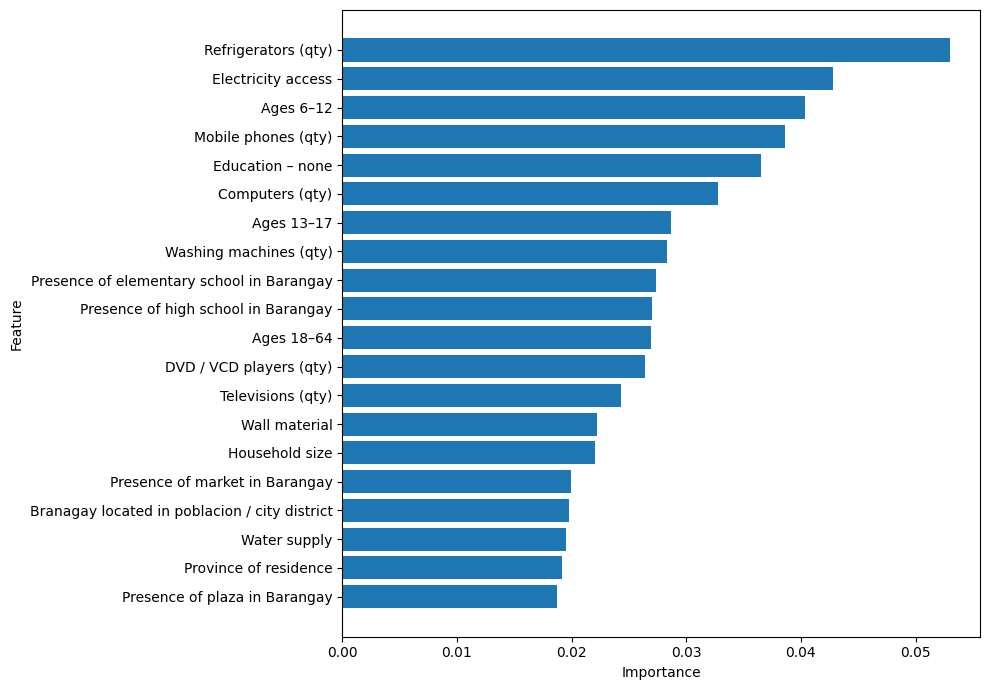

In [68]:

# Get feature importances from the trained classifier
feature_names = cat_vars + num_vars
importances = xgb_clf.feature_importances_

# Create a DataFrame for easy sorting and plotting
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot the top 20 features
# Map feature names to readable labels if available
feat_imp_df['label'] = feat_imp_df['feature'].map(label_map).fillna(feat_imp_df['feature'])
feat_imp_df_top20 = feat_imp_df.head(20)

plt.figure(figsize=(10, 7))
plt.barh(feat_imp_df_top20['label'], feat_imp_df_top20['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('picture/xgb_classifier_feature_importance.png')
plt.show()

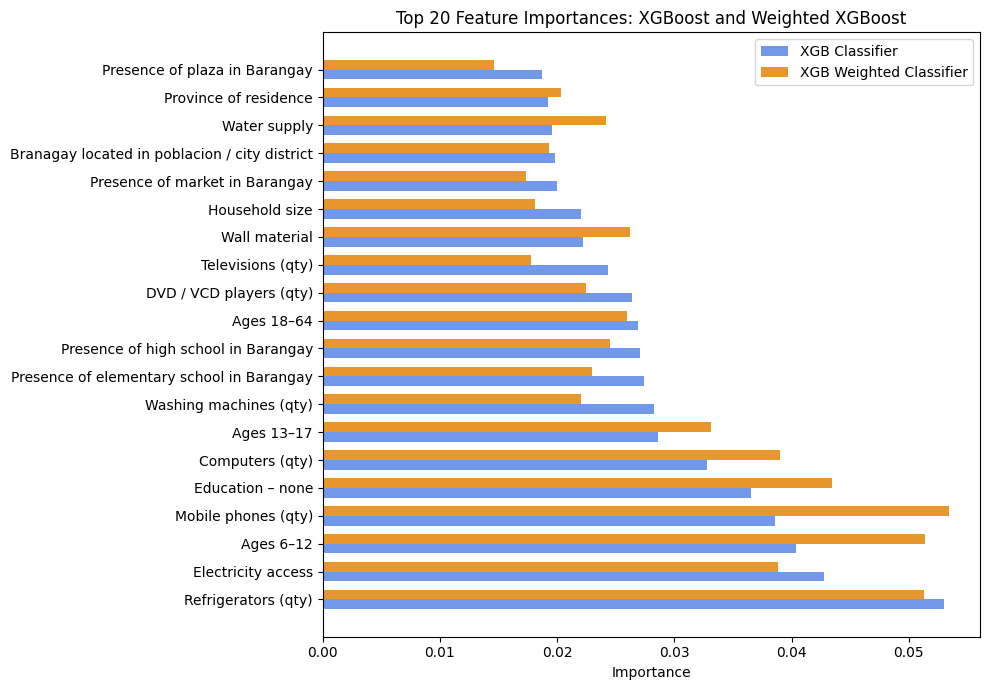

In [69]:
feature_names = cat_vars + num_vars
importances_clf = xgb_clf.feature_importances_
importances_clf_w = xgb_clf_w.feature_importances_

# Create a DataFrame with importance values
df_importance = pd.DataFrame({
    'feature': feature_names,
    'xgb_clf': importances_clf,
    'xgb_clf_w': importances_clf_w
})

# Sort by xgb_clf importance and take the top 20 features
df_importance = df_importance.sort_values('xgb_clf', ascending=False).head(20)

# Create an array for the y positions
y_pos = np.arange(len(df_importance))
height = 0.35

fig, ax = plt.subplots(figsize=(10,7))
ax.barh(y_pos - height/2, df_importance['xgb_clf'], height=height, label='XGB Classifier', color="#7299E9")
ax.barh(y_pos + height/2, df_importance['xgb_clf_w'], height=height, label='XGB Weighted Classifier', color='#E8972C')

ax.set_yticks(y_pos)
ax.set_yticklabels(df_importance['feature'].map(label_map).fillna(df_importance['feature']))
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importances: XGBoost and Weighted XGBoost')
ax.legend()

plt.tight_layout()
plt.savefig('picture/xgb_combined_feature_importance.png')
plt.show()

In [70]:
df_21['POOR_21'] = df_21['PCINC'] <= poverty_line_2021
df_18['POOR_18'] = df_18['PCINC'] <= df_18['poverty_line']

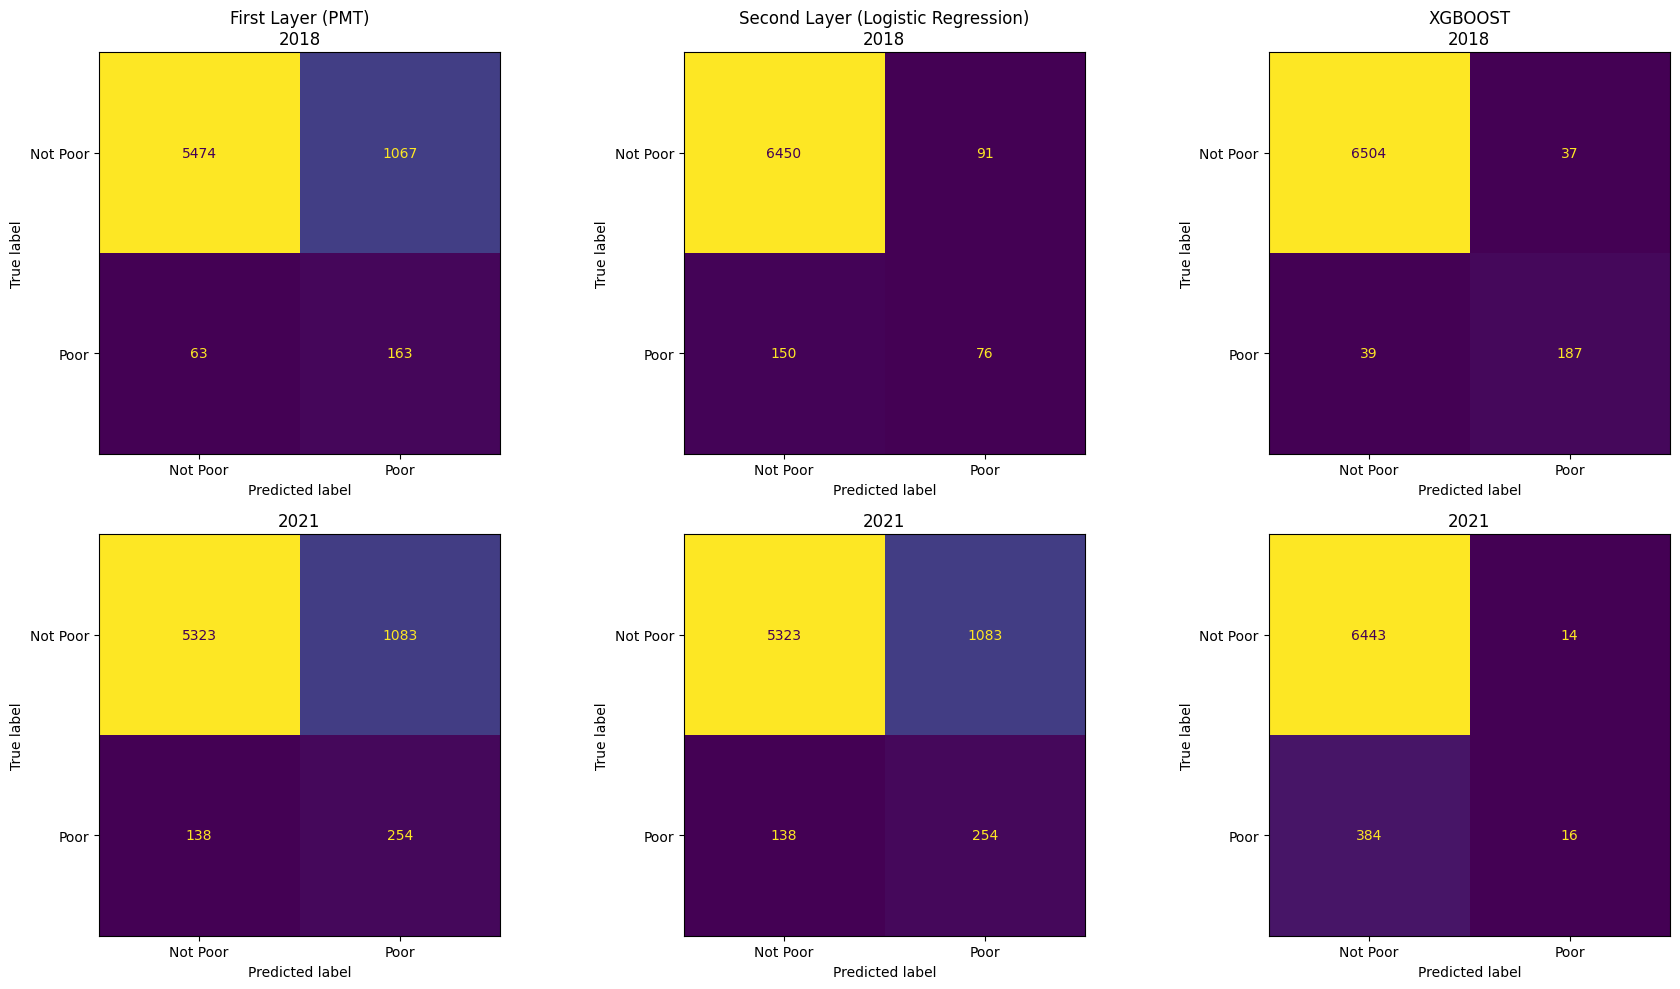

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- First Layer (PMT) ---
cm_pmt_18 = confusion_matrix(df_pmt2_18['POOR_18'], df_pmt2_18['POOR_PRE_18'])
ConfusionMatrixDisplay(cm_pmt_18, display_labels=['Not Poor', 'Poor']).plot(ax=axes[0, 0], colorbar=False,  values_format='d')
axes[0, 0].set_title("First Layer (PMT)\n2018")

cm_pmt_21 = confusion_matrix(df_pmt2_21['POOR_21'], df_pmt2_21['POOR_PRE_21'])
ConfusionMatrixDisplay(cm_pmt_21, display_labels=['Not Poor', 'Poor']).plot(ax=axes[1, 0], colorbar=False,  values_format='d')
axes[1, 0].set_title("2021")

# --- Second Layer (Logistic Regression) ---
cm_l2_18 = confusion_matrix(df_pmt2_18['POOR_18'], df_pmt2_18['poor_final'])
ConfusionMatrixDisplay(cm_l2_18, display_labels=['Not Poor', 'Poor']).plot(ax=axes[0, 1], colorbar=False,  values_format='d')
axes[0, 1].set_title("Second Layer (Logistic Regression)\n2018")

cm_l2_21 = confusion_matrix(df_pmt2_21['POOR_21'], df_pmt2_21['poor_final'])
ConfusionMatrixDisplay(cm_l2_21, display_labels=['Not Poor', 'Poor']).plot(ax=axes[1, 1], colorbar=False,  values_format='d')
axes[1, 1].set_title("2021")

# --- XGBOOST ---
cm_xgb_18 = confusion_matrix(df_18['POOR_18'], df_18['xgb_is_poor'])
ConfusionMatrixDisplay(cm_xgb_18, display_labels=['Not Poor', 'Poor']).plot(ax=axes[0, 2], colorbar=False,  values_format='d')
axes[0, 2].set_title("XGBOOST\n2018")

cm_xgb_21 = confusion_matrix(df_21['POOR_21'], df_21['xgb_is_poor'])
ConfusionMatrixDisplay(cm_xgb_21, display_labels=['Not Poor', 'Poor']).plot(ax=axes[1, 2], colorbar=False,  values_format='d')
axes[1, 2].set_title("2021")

plt.tight_layout()
plt.savefig("picture/confusion_matrix_comparison.png")
plt.show()


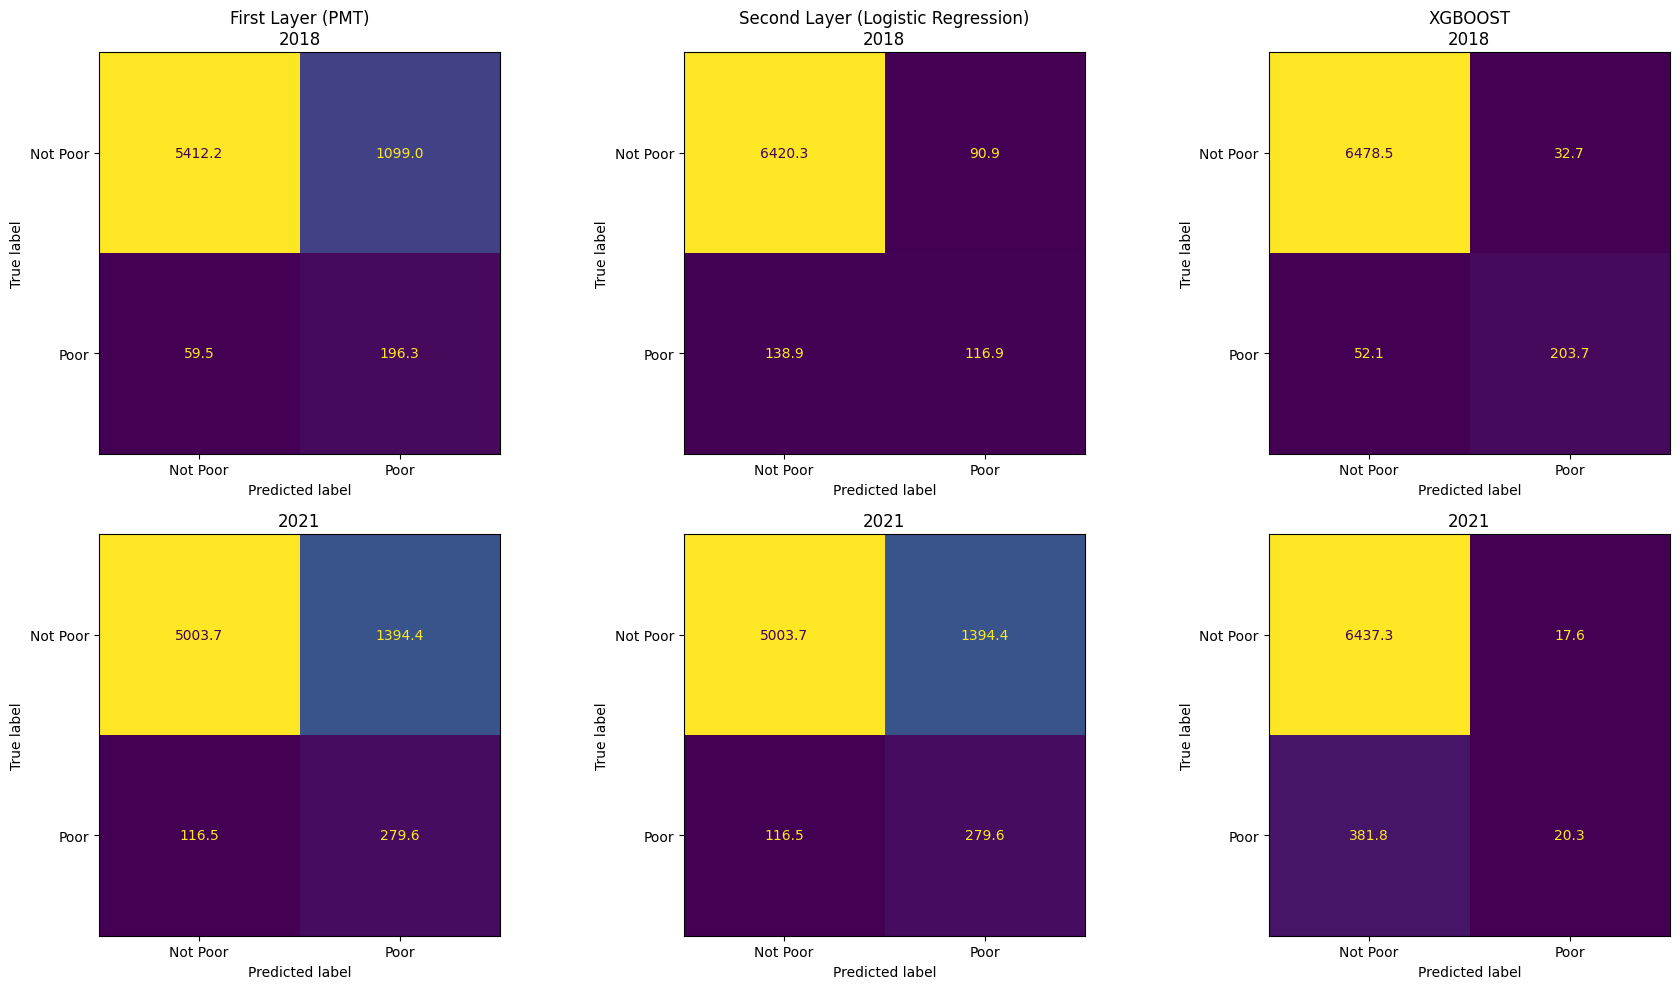

In [72]:
# Weighted confusion matrix comparison

w = df_18['w_normalized']  # use the normalized weights
w_21 = df_21['w_normalized']  # use the normalized weights for 2021
w_pmt2_18 = df_pmt2_18['w_normalized']
w_pmt2_21 = df_pmt2_21['w_normalized']


fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- First Layer (PMT) ---
cm_pmt_18 = confusion_matrix(df_pmt2_18['POOR_18'], df_pmt2_18['poor_s1_weighted'], sample_weight=w_pmt2_18)
ConfusionMatrixDisplay(cm_pmt_18, display_labels=['Not Poor', 'Poor']).plot(ax=axes[0, 0], colorbar=False,  values_format='.1f')
axes[0, 0].set_title("First Layer (PMT)\n2018")

cm_pmt_21 = confusion_matrix(df_pmt2_21['POOR_21'], df_pmt2_21['poor_s1_weighted'], sample_weight=w_pmt2_21)
ConfusionMatrixDisplay(cm_pmt_21, display_labels=['Not Poor', 'Poor']).plot(ax=axes[1, 0], colorbar=False,  values_format='.1f')
axes[1, 0].set_title("2021")

# --- Second Layer (Logistic Regression) ---
cm_l2_18 = confusion_matrix(df_pmt2_18['POOR_18'], df_pmt2_18['poor_final_w'], sample_weight=w_pmt2_18)
ConfusionMatrixDisplay(cm_l2_18, display_labels=['Not Poor', 'Poor']).plot(ax=axes[0, 1], colorbar=False,  values_format='.1f')
axes[0, 1].set_title("Second Layer (Logistic Regression)\n2018")

cm_l2_21 = confusion_matrix(df_pmt2_21['POOR_21'], df_pmt2_21['poor_final_w'], sample_weight=w_pmt2_21)
ConfusionMatrixDisplay(cm_l2_21, display_labels=['Not Poor', 'Poor']).plot(ax=axes[1, 1], colorbar=False,  values_format='.1f')
axes[1, 1].set_title("2021")

# --- XGBOOST ---
cm_xgb_18 = confusion_matrix(df_18['POOR_18'], df_18['xgb_is_poor_w'], sample_weight=w)
ConfusionMatrixDisplay(cm_xgb_18, display_labels=['Not Poor', 'Poor']).plot(ax=axes[0, 2], colorbar=False,  values_format='.1f')
axes[0, 2].set_title("XGBOOST\n2018")

cm_xgb_21 = confusion_matrix(df_21['POOR_21'], df_21['xgb_is_poor_w'], sample_weight=w_21)
ConfusionMatrixDisplay(cm_xgb_21, display_labels=['Not Poor', 'Poor']).plot(ax=axes[1, 2], colorbar=False,  values_format='.1f')
axes[1, 2].set_title("2021")

plt.tight_layout()
plt.savefig("picture/confusion_matrix_comparison_weighted.png")
plt.show()


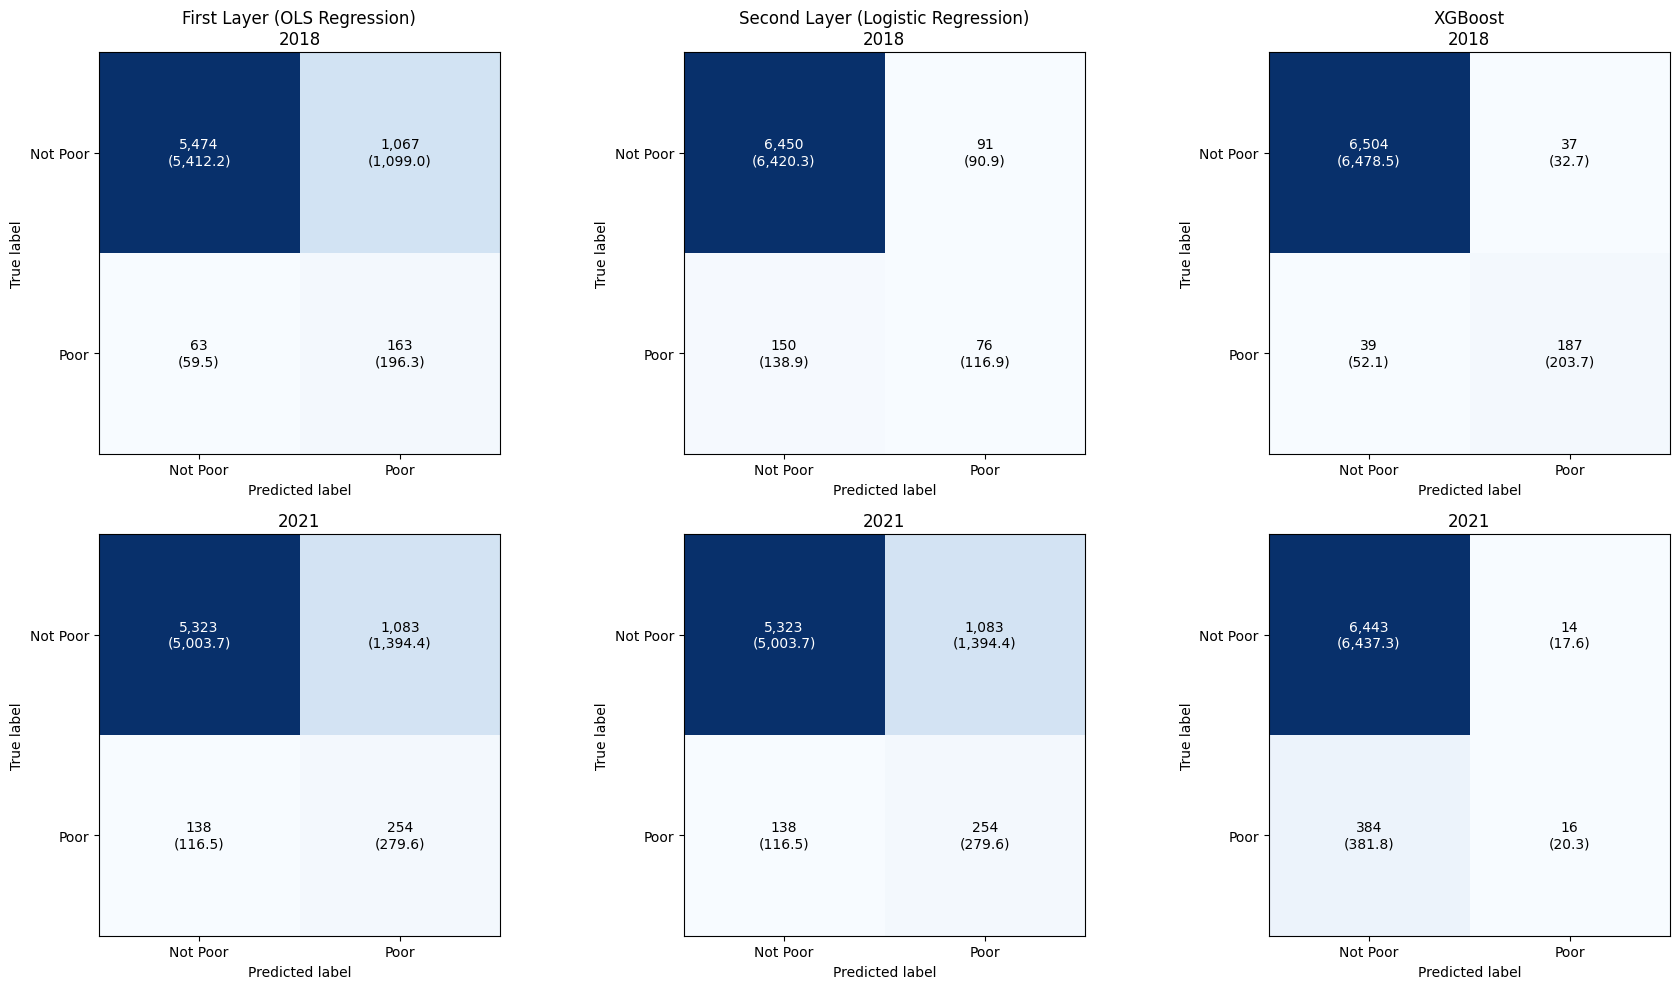

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm_two_numbers(
    ax,
    y_true,
    y_pred_unweighted,
    *,
    y_pred_weighted=None,        # if None, uses y_pred_unweighted
    sample_weight=None,          # weights used for the second line
    labels_order=None,           # e.g., [0, 1]; leave None to infer
    display_labels=('Not Poor', 'Poor'),
    title='',
    color_from='unweighted',     # 'unweighted' or 'weighted' (which matrix colors the heatmap)
    fmt_unw='{:,}',              # top line (unweighted) formatting
    fmt_wtd='{:,.1f}'            # bottom line (weighted) formatting
):
    # --- compute the two matrices ---
    if labels_order is None:
        # infer a stable order
        uniq = np.unique(np.concatenate([np.asarray(y_true), np.asarray(y_pred_unweighted)]))
        if y_pred_weighted is not None:
            uniq = np.unique(np.concatenate([uniq, np.asarray(y_pred_weighted)]))
        labels_order = list(uniq)

    cm_unw = confusion_matrix(y_true, y_pred_unweighted, labels=labels_order)

    if y_pred_weighted is None:
        y_pred_weighted = y_pred_unweighted
    cm_wtd = confusion_matrix(
        y_true, y_pred_weighted, labels=labels_order, sample_weight=sample_weight
    )

    # --- draw heatmap using one of the matrices for color ---
    cm_color = cm_unw if color_from == 'unweighted' else cm_wtd
    disp = ConfusionMatrixDisplay(cm_color, display_labels=display_labels)
    disp.plot(ax=ax, include_values=False, colorbar=False, cmap='Blues')
    ax.set_title(title)

    # --- annotate two numbers per cell ---
    thresh = cm_color.max() / 2.0 if cm_color.max() > 0 else 0
    for i in range(cm_unw.shape[0]):
        for j in range(cm_unw.shape[1]):
            ax.text(
                j, i, f"{fmt_unw.format(cm_unw[i, j])}\n({fmt_wtd.format(cm_wtd[i, j])})",
                ha='center', va='center', fontsize=10,
                color='white' if cm_color[i, j] > thresh else 'black'
            )

# ---------- your 2x3 figure with both numbers in each cell ----------
# weights you already defined:
# w, w_21, w_pmt2_18, w_pmt2_21

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# First Layer (PMT)
plot_cm_two_numbers(
    axes[0, 0],
    y_true=df_pmt2_18['POOR_18'],
    y_pred_unweighted=df_pmt2_18['POOR_PRE_18'],
    y_pred_weighted=df_pmt2_18['poor_s1_weighted'],
    sample_weight=w_pmt2_18,
    labels_order=[0, 1],
    display_labels=['Not Poor', 'Poor'],
    title='First Layer (OLS Regression)\n2018'
)
plot_cm_two_numbers(
    axes[1, 0],
    y_true=df_pmt2_21['POOR_21'],
    y_pred_unweighted=df_pmt2_21['POOR_PRE_21'],
    y_pred_weighted=df_pmt2_21['poor_s1_weighted'],
    sample_weight=w_pmt2_21,
    labels_order=[0, 1],
    display_labels=['Not Poor', 'Poor'],
    title='2021'
)

# Second Layer (Logistic Regression)
plot_cm_two_numbers(
    axes[0, 1],
    y_true=df_pmt2_18['POOR_18'],
    y_pred_unweighted=df_pmt2_18['poor_final'],
    y_pred_weighted=df_pmt2_18['poor_final_w'],
    sample_weight=w_pmt2_18,
    labels_order=[0, 1],
    display_labels=['Not Poor', 'Poor'],
    title='Second Layer (Logistic Regression)\n2018'
)
plot_cm_two_numbers(
    axes[1, 1],
    y_true=df_pmt2_21['POOR_21'],
    y_pred_unweighted=df_pmt2_21['poor_final'],
    y_pred_weighted=df_pmt2_21['poor_final_w'],
    sample_weight=w_pmt2_21,
    labels_order=[0, 1],
    display_labels=['Not Poor', 'Poor'],
    title='2021'
)

# XGBOOST
plot_cm_two_numbers(
    axes[0, 2],
    y_true=df_18['POOR_18'],
    y_pred_unweighted=df_18['xgb_is_poor'],
    y_pred_weighted=df_18['xgb_is_poor_w'],
    sample_weight=w,
    labels_order=[0, 1],
    display_labels=['Not Poor', 'Poor'],
    title='XGBoost\n2018'
)
plot_cm_two_numbers(
    axes[1, 2],
    y_true=df_21['POOR_21'],
    y_pred_unweighted=df_21['xgb_is_poor'],
    y_pred_weighted=df_21['xgb_is_poor_w'],
    sample_weight=w_21,
    labels_order=[0, 1],
    display_labels=['Not Poor', 'Poor'],
    title='2021'
)

plt.tight_layout()
plt.savefig("picture/confusion_matrix_comparison_dual.png", dpi=300)
plt.show()


In [74]:
def compute_inclusion_exclusion(y_true, y_pred):
    tp = ((y_pred) & (y_true)).sum()
    fp = ((y_pred) & (~y_true)).sum()
    fn = ((~y_pred) & (y_true)).sum()
    inclusion_error = fp / (tp + fp) if (tp + fp) else float('nan')
    exclusion_error = fn / (tp + fn) if (tp + fn) else float('nan')
    return inclusion_error, exclusion_error

# PMT Layer 1 (2018)
inc_pmt_18, exc_pmt_18 = compute_inclusion_exclusion(df_pmt2_18['POOR_18'], df_pmt2_18['POOR_PRE_18'])
print(f"PMT 2018: Inclusion error: {inc_pmt_18:.2%}, Exclusion error: {exc_pmt_18:.2%}")

# PMT Layer 1 (2021)
inc_pmt_21, exc_pmt_21 = compute_inclusion_exclusion(df_pmt2_21['POOR_21'], df_pmt2_21['POOR_PRE_21'])
print(f"PMT 2021: Inclusion error: {inc_pmt_21:.2%}, Exclusion error: {exc_pmt_21:.2%}")

# Logistic Regression Layer 2 (2018)
inc_l2_18, exc_l2_18 = compute_inclusion_exclusion(df_pmt2_18['POOR_18'], df_pmt2_18['poor_final'])
print(f"Logit 2018: Inclusion error: {inc_l2_18:.2%}, Exclusion error: {exc_l2_18:.2%}")

# Logistic Regression Layer 2 (2021)
inc_l2_21, exc_l2_21 = compute_inclusion_exclusion(df_pmt2_21['POOR_21'], df_pmt2_21['poor_final'])
print(f"Logit 2021: Inclusion error: {inc_l2_21:.2%}, Exclusion error: {exc_l2_21:.2%}")

# XGBoost (2018)
inc_xgb_18, exc_xgb_18 = compute_inclusion_exclusion(df_18['POOR_18'], df_18['xgb_is_poor'])
print(f"XGB 2018: Inclusion error: {inc_xgb_18:.2%}, Exclusion error: {exc_xgb_18:.2%}")

# XGBoost (2021)
inc_xgb_21, exc_xgb_21 = compute_inclusion_exclusion(df_21['POOR_21'], df_21['xgb_is_poor'])
print(f"XGB 2021: Inclusion error: {inc_xgb_21:.2%}, Exclusion error: {exc_xgb_21:.2%}")

PMT 2018: Inclusion error: 86.75%, Exclusion error: 27.88%
PMT 2021: Inclusion error: 81.00%, Exclusion error: 35.20%
Logit 2018: Inclusion error: 54.49%, Exclusion error: 66.37%
Logit 2021: Inclusion error: 81.00%, Exclusion error: 35.20%
XGB 2018: Inclusion error: 16.52%, Exclusion error: 17.26%
XGB 2021: Inclusion error: 46.67%, Exclusion error: 96.00%


In [75]:
def compute_inclusion_exclusion(y_true, y_pred, df_weights):
    # Normalize the weights
    weights_norm = df_weights['w_normalized']
    
    # Use normalized weights for weighted sum computations
    tp = (weights_norm * (y_pred & y_true).astype(int)).sum()
    fp = (weights_norm * (y_pred & (~y_true)).astype(int)).sum()
    fn = (weights_norm * ((~y_pred) & y_true).astype(int)).sum()
    
    inclusion_error = fp / (tp + fp) if (tp + fp) > 0 else float('nan')
    exclusion_error = fn / (tp + fn) if (tp + fn) > 0 else float('nan')
    return inclusion_error, exclusion_error

# Example usage:

# PMT Layer 1 (2018)
inc_pmt_18, exc_pmt_18 = compute_inclusion_exclusion(
    df_pmt2_18['POOR_18'], df_pmt2_18['poor_s1_weighted'], df_pmt2_18
)
print(f"PMT 2018: Inclusion error: {inc_pmt_18:.2%}, Exclusion error: {exc_pmt_18:.2%}")

# PMT Layer 1 (2021):
inc_pmt_21, exc_pmt_21 = compute_inclusion_exclusion(
    df_pmt2_21['POOR_21'], df_pmt2_21['poor_s1_weighted'], df_pmt2_21
)
print(f"PMT 2021: Inclusion error: {inc_pmt_21:.2%}, Exclusion error: {exc_pmt_21:.2%}")

# Logistic Regression Layer 2 (2018):
inc_l2_18, exc_l2_18 = compute_inclusion_exclusion(
    df_pmt2_18['POOR_18'], df_pmt2_18['poor_final_w'], df_pmt2_18
)
print(f"Logit 2018: Inclusion error: {inc_l2_18:.2%}, Exclusion error: {exc_l2_18:.2%}")

# Logistic Regression Layer 2 (2021):
inc_l2_21, exc_l2_21 = compute_inclusion_exclusion(
    df_pmt2_21['POOR_21'], df_pmt2_21['poor_final_w'], df_pmt2_21
)
print(f"Logit 2021: Inclusion error: {inc_l2_21:.2%}, Exclusion error: {exc_l2_21:.2%}")

# XGBoost (2018):
inc_xgb_18, exc_xgb_18 = compute_inclusion_exclusion(
    df_18['POOR_18'], df_18['xgb_is_poor_w'], df_18
)
print(f"XGB 2018: Inclusion error: {inc_xgb_18:.2%}, Exclusion error: {exc_xgb_18:.2%}")

# XGBoost (2021):
inc_xgb_21, exc_xgb_21 = compute_inclusion_exclusion(
    df_21['POOR_21'], df_21['xgb_is_poor_w'], df_21
)
print(f"XGB 2021: Inclusion error: {inc_xgb_21:.2%}, Exclusion error: {exc_xgb_21:.2%}")

PMT 2018: Inclusion error: 84.85%, Exclusion error: 23.26%
PMT 2021: Inclusion error: 83.30%, Exclusion error: 29.41%
Logit 2018: Inclusion error: 43.75%, Exclusion error: 54.28%
Logit 2021: Inclusion error: 83.30%, Exclusion error: 29.41%
XGB 2018: Inclusion error: 13.85%, Exclusion error: 20.36%
XGB 2021: Inclusion error: 46.39%, Exclusion error: 94.95%


In [76]:
labels = cols_no_cat

mean_18 = df_18_test[labels].mean()
mean_21 = df_21[labels].mean()
mean_diffs = mean_21 - mean_18

min_diff = mean_diffs.min()
max_diff = mean_diffs.max()
mean_diffs_norm = (mean_diffs - min_diff) / (max_diff - min_diff) if max_diff > min_diff else mean_diffs

/var/folders/x5/pd9ssg3n4cd2x2yf5kvq955r0000gp/T/ipykernel_80314/4102598207.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, mean_diffs_norm[i] + 0.02, f"{raw_diff:.2f}", ha='center', va='bottom', fontsize=8, rotation=90)


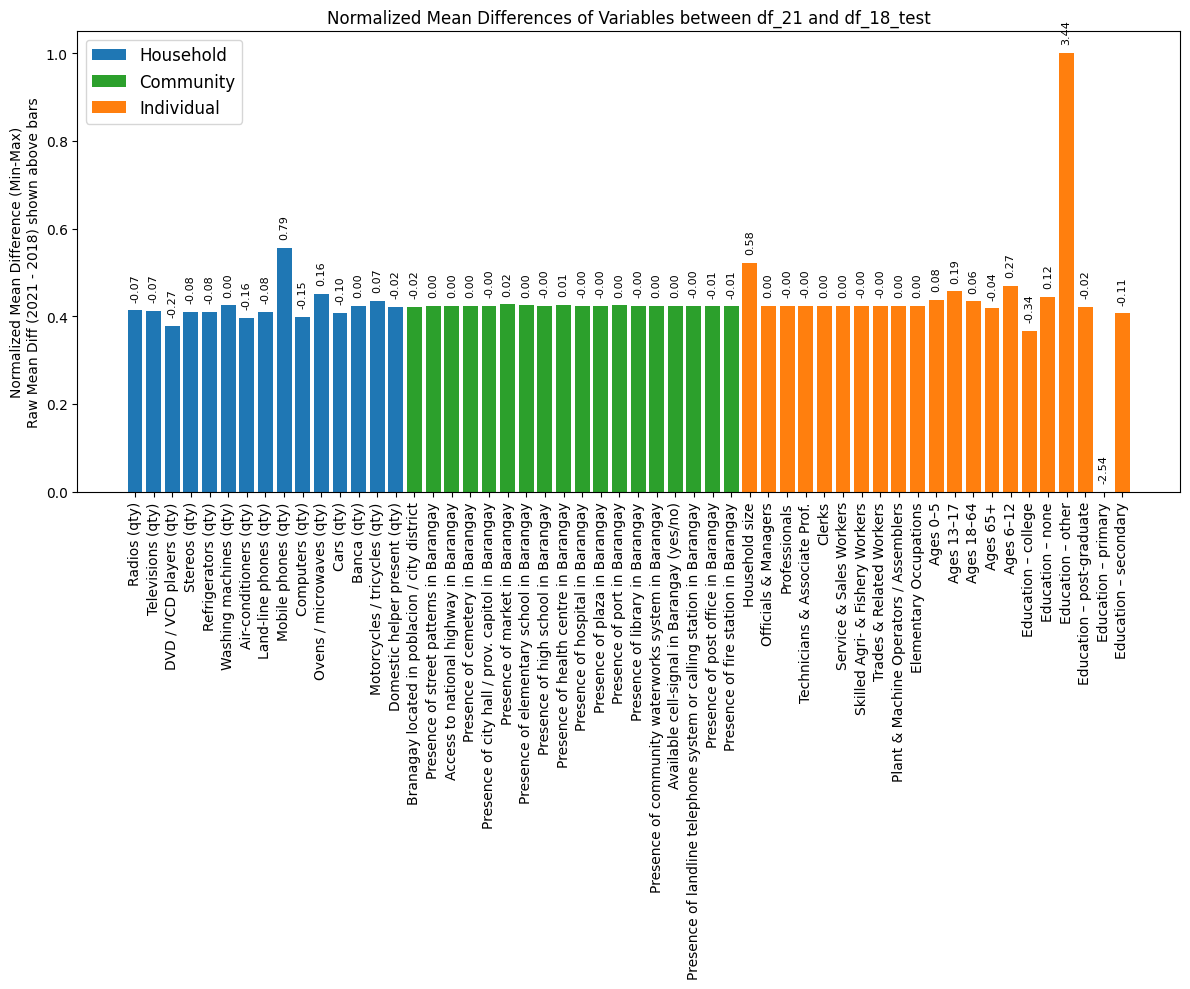

In [77]:
from matplotlib.patches import Patch



# Relabel using label_map
labels_relabel = [label_map.get(label, label) for label in labels]

# The line at $SELECTION_PLACEHOLDER$ is not needed and can be removed.
# If you want to get the household variable names present in labels, use:
hh = [v for v in real_hh_ind if v in labels]
id = [v for v in real_id_ind if v in labels]
com = [v for v in real_com_ind if v in labels]


# Assign colors to groups
hh_len = len(hh)
id_len = len(id)
com_len = len(com)

bar_colors = (
    ['tab:blue'] * hh_len +
    ['tab:green'] * com_len +
    ['tab:orange'] * id_len
)


plt.figure(figsize=(12, 10))
bars = plt.bar(labels_relabel, mean_diffs_norm, color=bar_colors)
plt.xticks(rotation=90)
plt.ylabel('Normalized Mean Difference (Min-Max)\nRaw Mean Diff (2021 - 2018) shown above bars')

for i, (label, raw_diff) in enumerate(zip(labels_relabel, mean_diffs)):
    plt.text(i, mean_diffs_norm[i] + 0.02, f"{raw_diff:.2f}", ha='center', va='bottom', fontsize=8, rotation=90)



# Add group labels
hh_end = hh_len - 1
com_end = hh_len + com_len - 1

plt.text(hh_end/2, -0.15, '', ha='center', va='top', fontsize=12, color='tab:blue')
plt.text((hh_end+1 + com_end)/2, -0.15, '', ha='center', va='top', fontsize=12, color='tab:green')
plt.text((com_end+1 + len(labels)-1)/2, -0.15, '', ha='center', va='top', fontsize=12, color='tab:orange')

legend_elements = [
    Patch(facecolor='tab:blue', label='Household'),
    Patch(facecolor='tab:green', label='Community'),
    Patch(facecolor='tab:orange', label='Individual')
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=12)

plt.title('Normalized Mean Differences of Variables between df_21 and df_18_test')
plt.tight_layout()
plt.savefig('picture/mean_differences_2021_vs_2018_normalized.png')
plt.show()


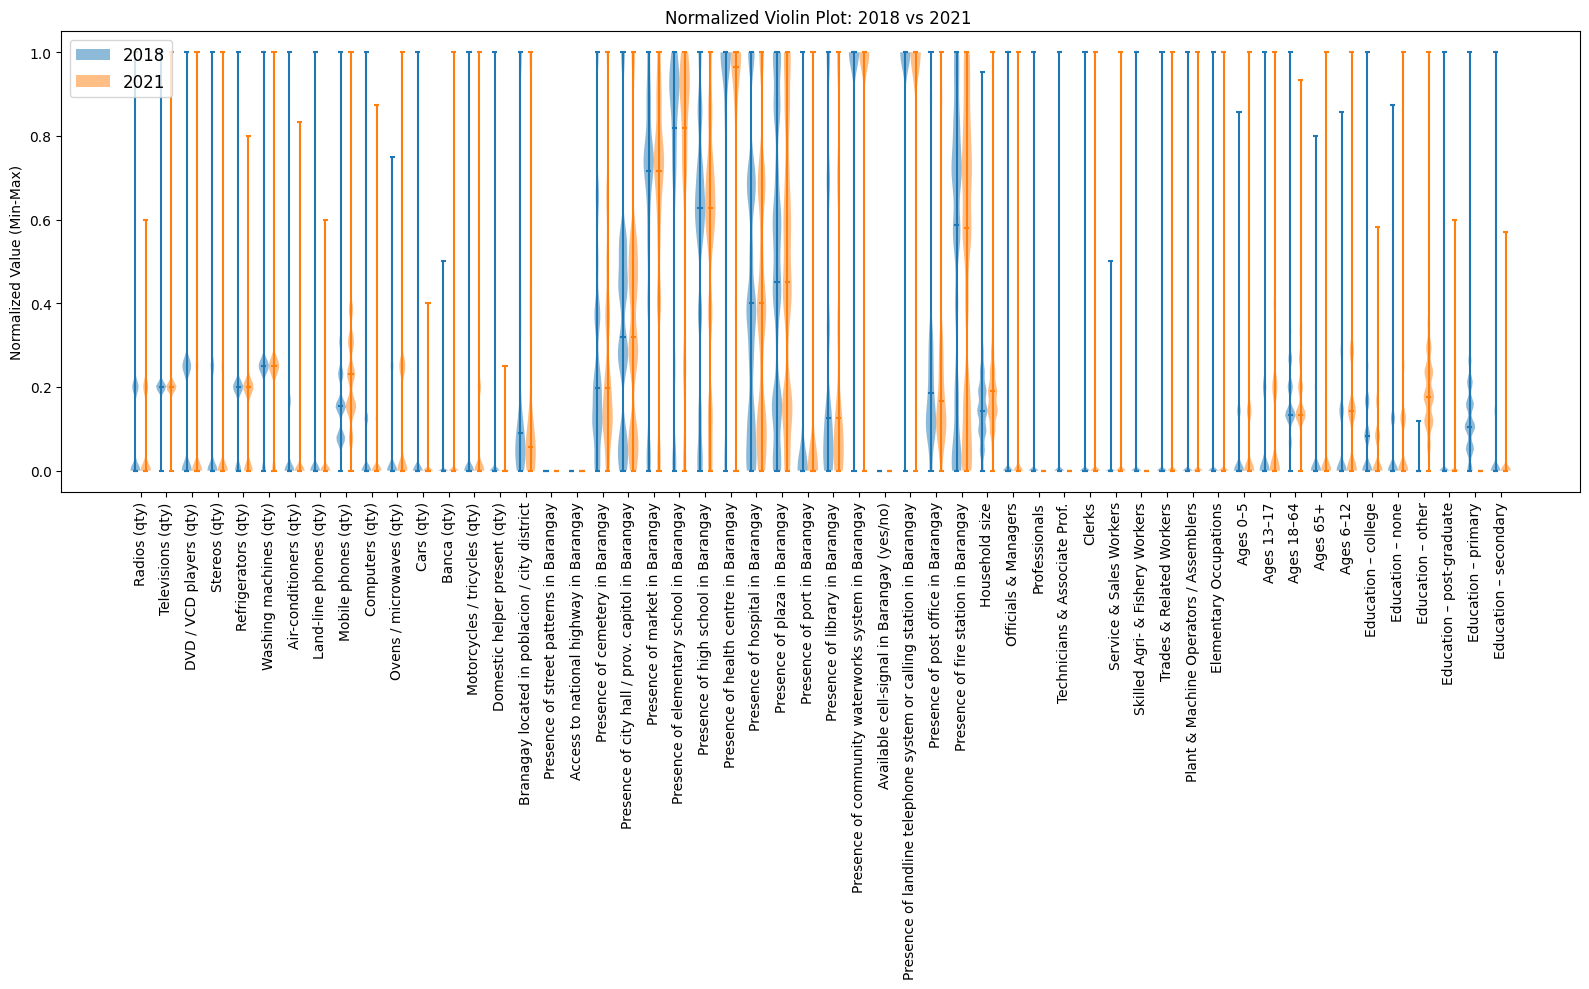

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

labels = cols_no_cat

# Min-max normalization using both years' data for each variable
normed_18 = []
normed_21 = []
for col in labels:
    vals_18 = df_18_test[col].dropna()
    vals_21 = df_21[col].dropna()
    all_vals = pd.concat([vals_18, vals_21])
    min_val, max_val = all_vals.min(), all_vals.max()
    # Avoid division by zero
    if max_val > min_val:
        normed_18.append((vals_18 - min_val) / (max_val - min_val))
        normed_21.append((vals_21 - min_val) / (max_val - min_val))
    else:
        normed_18.append(vals_18 * 0)
        normed_21.append(vals_21 * 0)

labels_relabel = [label_map.get(lbl, lbl) for lbl in labels]

plt.figure(figsize=(16, 10))
parts = plt.violinplot(normed_18, positions=np.arange(len(labels)), widths=0.4, showmeans=False, showmedians=True)
parts2 = plt.violinplot(normed_21, positions=np.arange(len(labels)) + 0.4, widths=0.4, showmeans=False, showmedians=True)

for pc in parts['bodies']:
    pc.set_facecolor('tab:blue')
    pc.set_alpha(0.5)
for pc in parts2['bodies']:
    pc.set_facecolor('tab:orange')
    pc.set_alpha(0.5)


plt.xticks(np.arange(len(labels)) + 0.2, labels_relabel, rotation=90)
plt.ylabel('Normalized Value (Min-Max)')
plt.title('Normalized Violin Plot: 2018 vs 2021 ')
plt.legend([Patch(facecolor='tab:blue', alpha=0.5), Patch(facecolor='tab:orange', alpha=0.5)],
           ['2018', '2021'], loc='upper left', fontsize=12)
plt.tight_layout()
Path('picture').mkdir(exist_ok=True)
plt.savefig('picture/violinplot_normalized_2018_vs_2021.png', dpi=300)
plt.show()


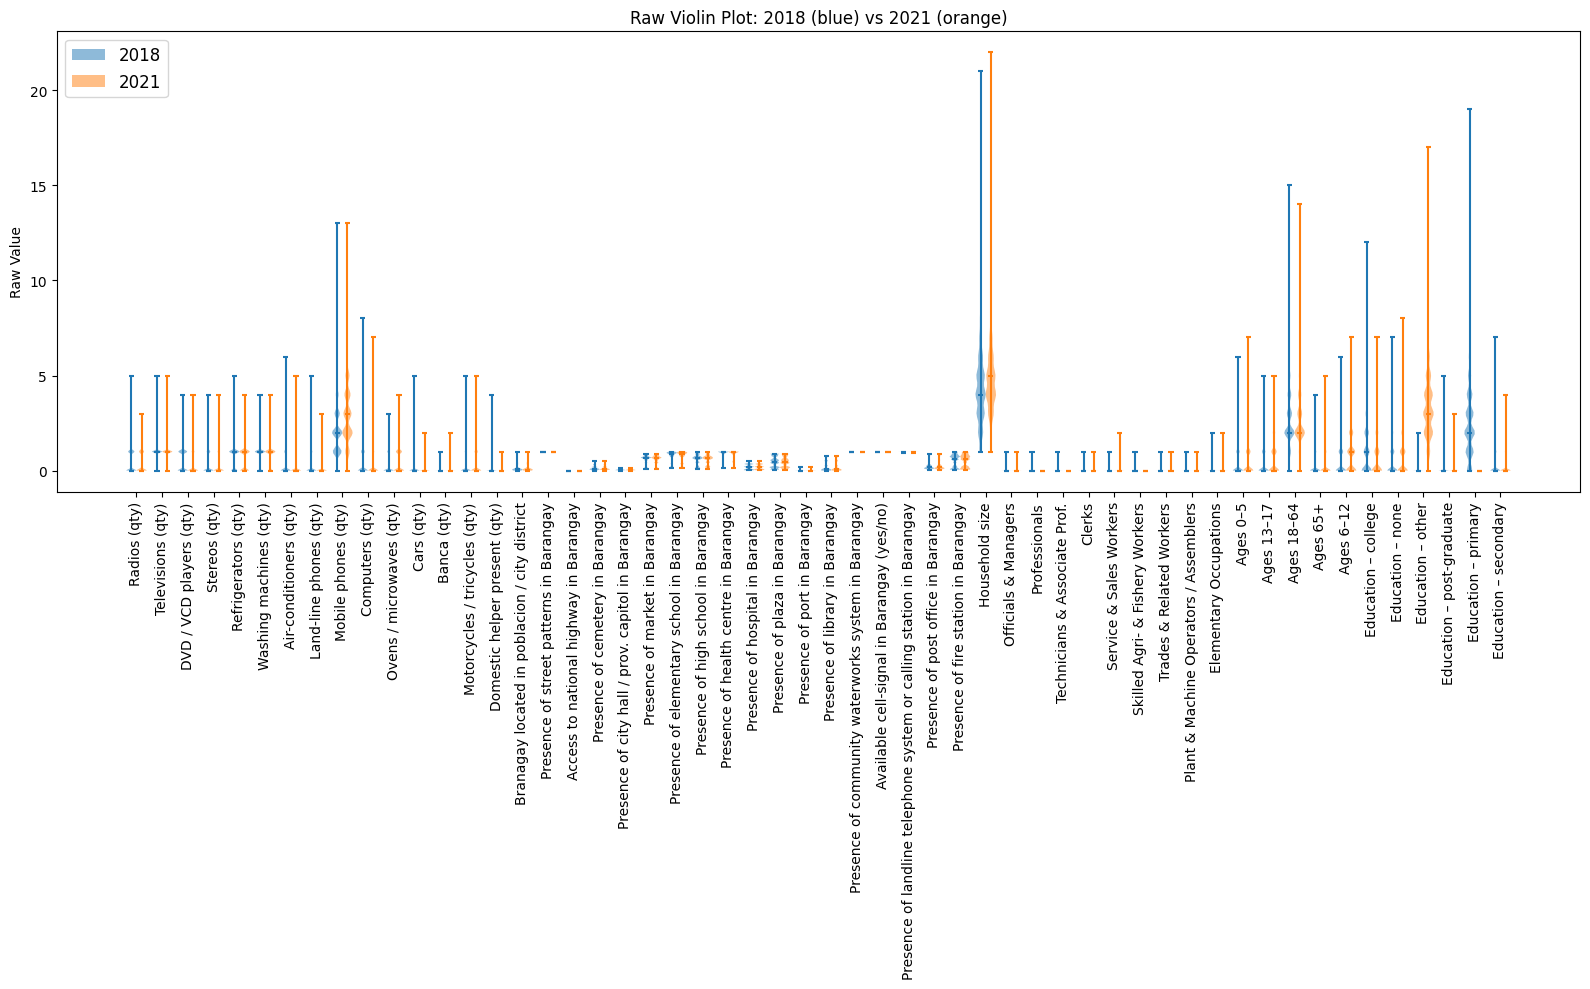

In [79]:
labels
from pathlib import Path

import matplotlib.pyplot as plt

labels = cols_no_cat

raw_18 = [df_18_test[col].dropna() for col in labels]
raw_21 = [df_21[col].dropna() for col in labels]

labels_relabel = [label_map.get(lbl, lbl) for lbl in labels]

plt.figure(figsize=(16, 10))
parts = plt.violinplot(raw_18, positions=np.arange(len(labels)), widths=0.4, showmeans=False, showmedians=True)
parts2 = plt.violinplot(raw_21, positions=np.arange(len(labels)) + 0.4, widths=0.4, showmeans=False, showmedians=True)

for pc in parts['bodies']:
    pc.set_facecolor('tab:blue')
    pc.set_alpha(0.5)
for pc in parts2['bodies']:
    pc.set_facecolor('tab:orange')
    pc.set_alpha(0.5)

plt.xticks(np.arange(len(labels)) + 0.2, labels_relabel, rotation=90)
plt.ylabel('Raw Value')
plt.title('Raw Violin Plot: 2018 (blue) vs 2021 (orange)')
plt.legend([Patch(facecolor='tab:blue', alpha=0.5), Patch(facecolor='tab:orange', alpha=0.5)],
           ['2018', '2021'], loc='upper left', fontsize=12)
plt.tight_layout()
Path('picture').mkdir(exist_ok=True)
plt.savefig('picture/violinplot_raw_2018_vs_2021.png', dpi=300)
plt.show()

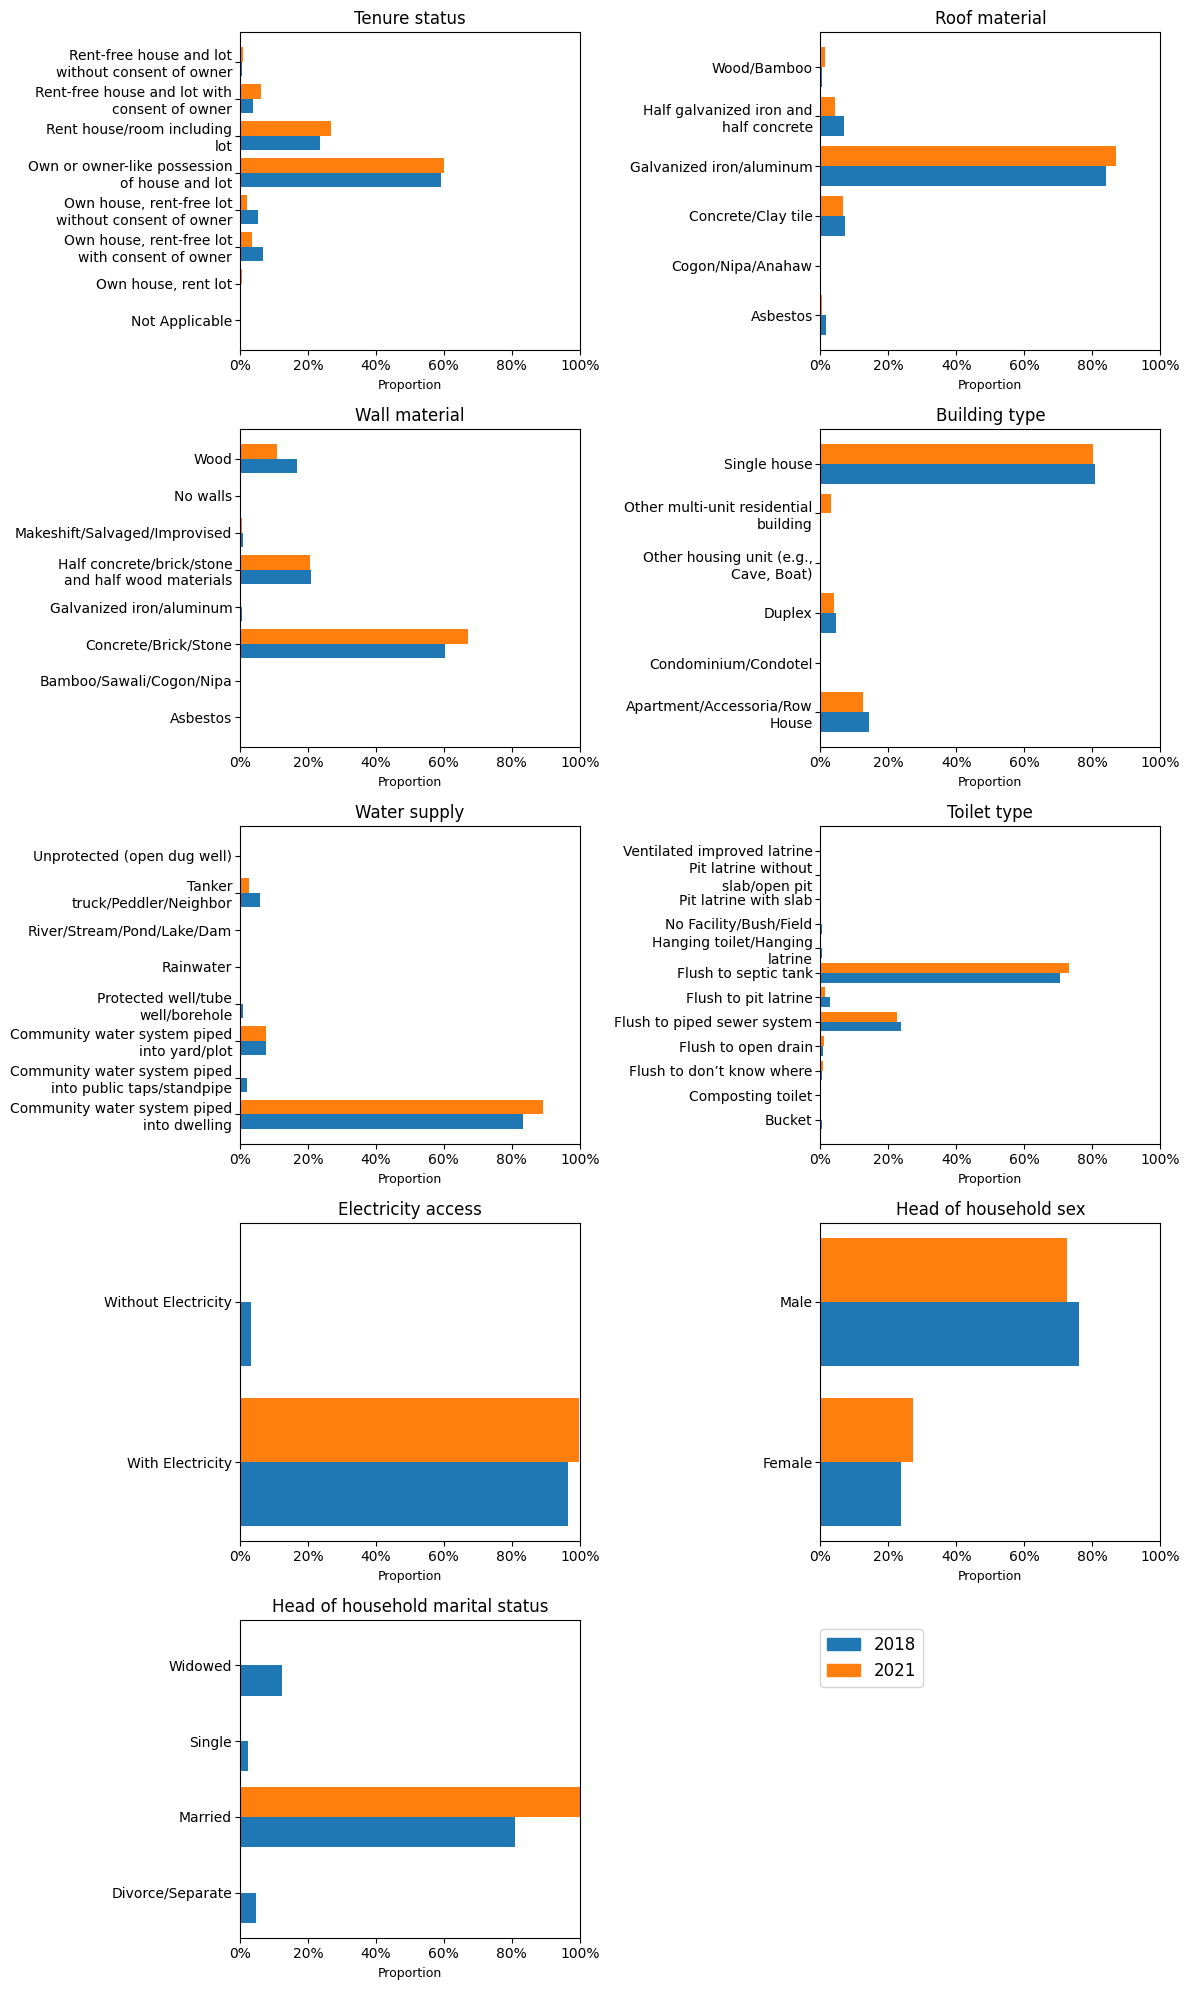

In [80]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from textwrap import wrap
import pandas as pd  # if you want the nice NaN label mapping

n = len(cat_vars)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
axes = axes.flatten()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, var in enumerate(cat_vars):
    if var in df_18.columns and var in df_21.columns:
        vc_18 = df_18[var].value_counts(normalize=True, dropna=True)
        vc_21 = df_21[var].value_counts(normalize=True, dropna=True)

        # clean category labels (keep NaN as a readable string)
        def lab(x):
            return "Missing" if (isinstance(x, float) and pd.isna(x)) else str(x)

        vc_18.index = vc_18.index.map(lab)
        vc_21.index = vc_21.index.map(lab)

        categories = sorted(set(vc_18.index).union(vc_21.index))
        vals_18 = [vc_18.get(cat, 0.0) for cat in categories]
        vals_21 = [vc_21.get(cat, 0.0) for cat in categories]

        y = np.arange(len(categories))
        ax = axes[i]  # <-- define ax BEFORE using it

        # bars
        ax.barh(y - 0.2, vals_18, height=0.4, label='2018')
        ax.barh(y + 0.2, vals_21, height=0.4, label='2021')

        # wrapped y-tick labels (set ONCE)
        WRAP, FS, SP = 28, 10, 1.3
        wrapped = ['\n'.join(wrap(c, WRAP, break_long_words=False)) for c in categories]
        ax.set(yticks=y, yticklabels=wrapped)       # set ticks & labels together
        ax.tick_params(axis='y', labelsize=FS, pad=2)
        for t in ax.get_yticklabels():
            t.set_linespacing(SP)
            t.set_ha('right')

        ax.set_xlim(0, 1)
        ax.set_xlabel('Proportion', fontsize=9)
        ax.set_title(f'{label_map.get(var, var)}', fontsize=12)
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))

# hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

legend_handles = [
    mpatches.Patch(color=colors[0], label='2018'),
    mpatches.Patch(color=colors[1], label='2021')
]
fig.legend(handles=legend_handles, loc='lower right', bbox_to_anchor=(0.78, 0.15), fontsize=12)

# give long labels room
plt.tight_layout()
plt.savefig('picture/categorical_value_comparison.png', dpi=150)
plt.show()


## Transition matrix

In [81]:
number_to_name = {
    801: "Caloocan City",
    802: "City of Las Piñas",
    803: "City of Makati",
    804: "City of Malabon",
    805: "City of Mandaluyong",
    806: "City of Manila",
    807: "City of Marikina",
    808: "City of Muntinlupa",
    809: "City of Navotas",
    810: "City of Parañaque",
    811: "Pasay City",
    812: "City of Pasig",
    813: "Quezon City",
    814: "City of San Juan",
    815: "Taguig City",
    816: "City of Valenzuela",
    817: "Pateros",
}

        Actual 2018       Actual 2021       Logistic 2018       Logistic 2021  \
POOR_18       False True        False True          False True          False   
RPROV                                                                           
801.0           580    37         733    61           583    34           562   
802.0           303    11         392    32           306     8           307   
803.0           178     2         220    10           180     0           217   
804.0           688    17         519    25           693    12           444   
806.0           506    25         370    13           505    26           262   
807.0           463    15         377    17           470     8           276   
808.0           482    11         478    23           491     2           394   
809.0           701    31         657    39           708    24           449   
810.0           319     5         295    24           323     1           267   
811.0           413    17   

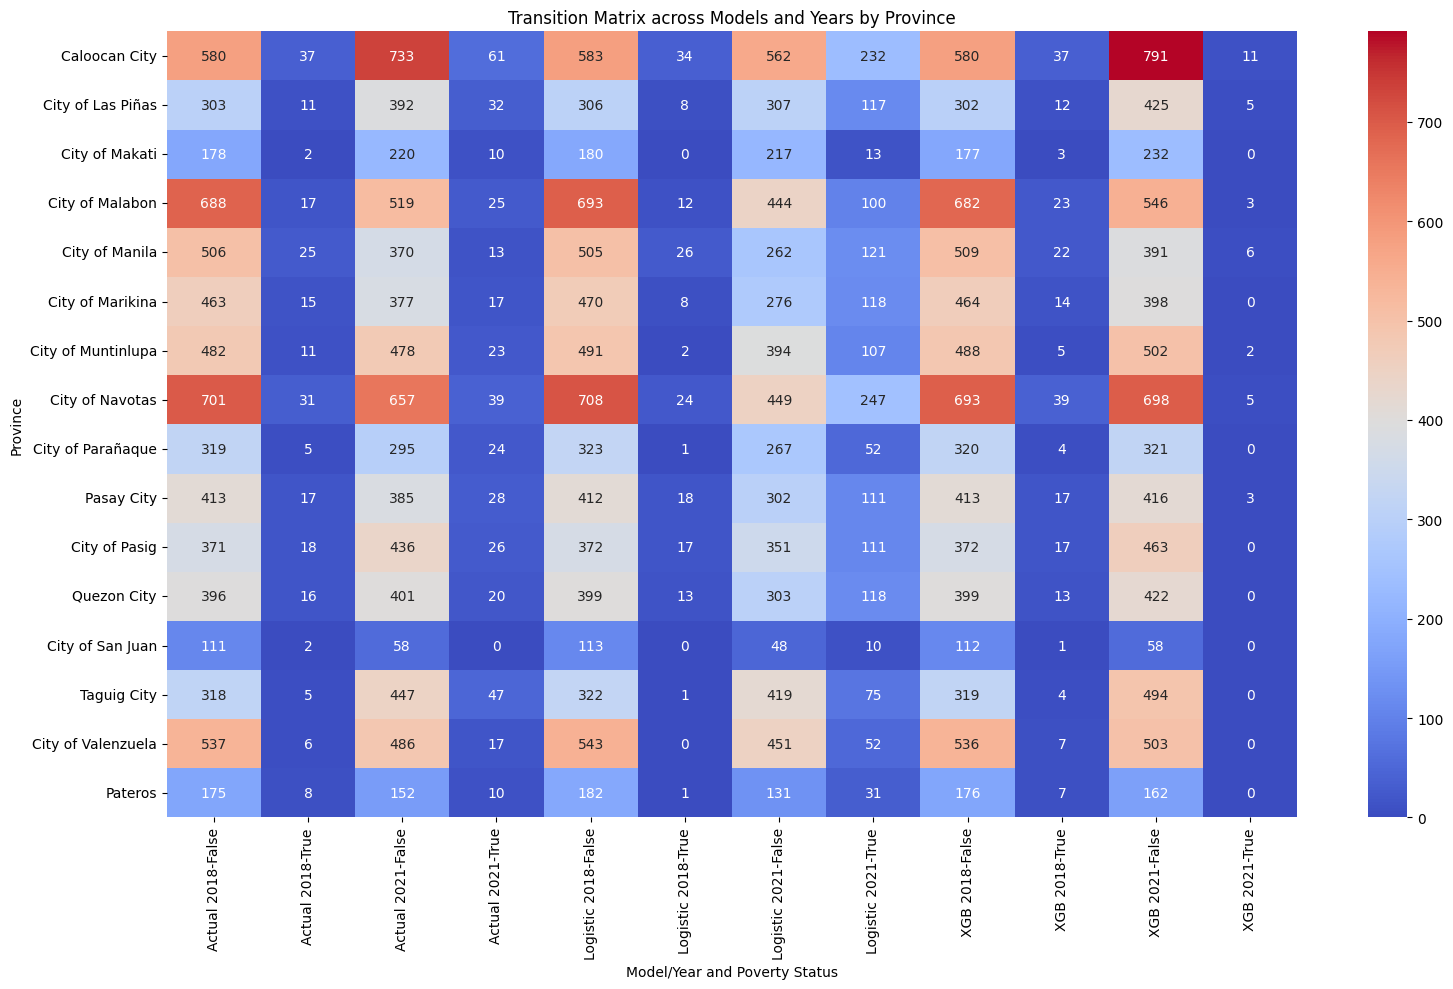

In [82]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



# Aggregate the counts per province for 2018 and 2021 separately.
agg_18 = df_pmt2_18.groupby('RPROV')['POOR_18'].value_counts().unstack(fill_value=0)
agg_21 = df_pmt2_21.groupby('RPROV')['POOR_21'].value_counts().unstack(fill_value=0)
agg_18_pred = df_pmt2_18.groupby('RPROV')['poor_final_w'].value_counts().unstack(fill_value=0)
agg_21_pred = df_pmt2_21.groupby('RPROV')['poor_final_w'].value_counts().unstack(fill_value=0)
agg_18_xgb = df_18.groupby('RPROV')['xgb_is_poor_w'].value_counts().unstack(fill_value=0)
agg_21_xgb = df_21.groupby('RPROV')['xgb_is_poor_w'].value_counts().unstack(fill_value=0)

transition_matrix = pd.concat({
    'Actual 2018': agg_18,
    'Actual 2021': agg_21,
    'Logistic 2018': agg_18_pred,
    'Logistic 2021': agg_21_pred,
    'XGB 2018': agg_18_xgb,
    'XGB 2021': agg_21_xgb,
}, axis=1)

print(transition_matrix)


# Optionally, plot the whole transition matrix as a single heatmap.
# Label the RPROV index using the name_to_3dig mapping.
transition_matrix.index = transition_matrix.index.map(number_to_name)
plt.figure(figsize=(16, 10))
sns.heatmap(transition_matrix, annot=True, fmt='.0f', cmap='coolwarm', cbar=True)
plt.title("Transition Matrix across Models and Years by Province")
plt.ylabel("Province")
plt.xlabel("Model/Year and Poverty Status")
plt.tight_layout()
plt.show()





 

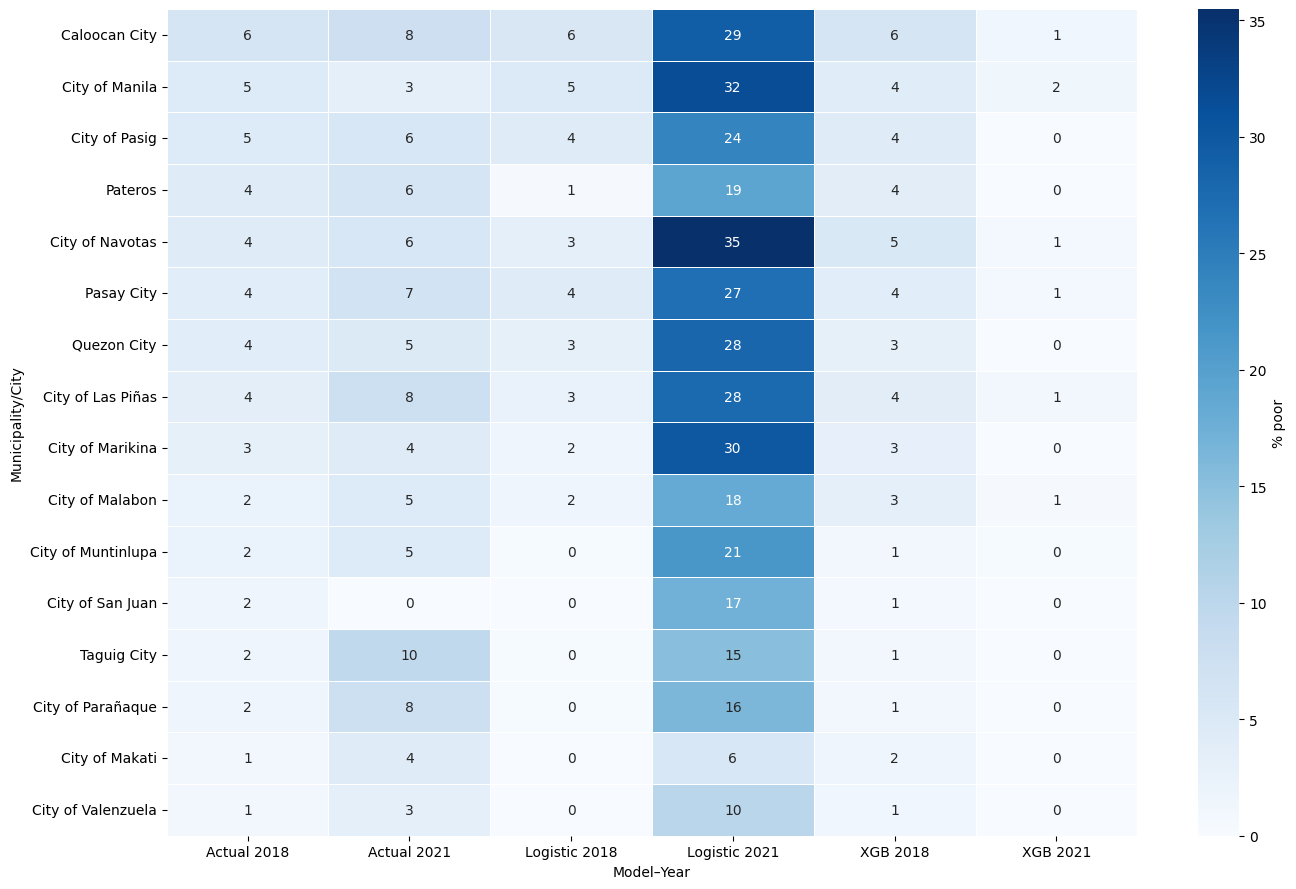

In [83]:
# Collapse True/False into ONE % column per model–year
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

def pct_true_by_province(df, prov_col, status_col):
    # works for boolean or 0/1; normalize=True → row shares
    vc = (df.groupby(prov_col)[status_col]
            .value_counts(normalize=True)
            .unstack(fill_value=0)                    # columns: False/True (or 0/1)
         )
    # make sure we pick the "True" column robustly
    true_col = True if True in vc.columns else 1
    return vc[true_col] * 100.0                      # percentage poor

pct = pd.concat({
    "Actual 2018":   pct_true_by_province(df_pmt2_18, "RPROV", "POOR_18"),
    "Actual 2021":   pct_true_by_province(df_pmt2_21, "RPROV", "POOR_21"),
    "Logistic 2018": pct_true_by_province(df_pmt2_18, "RPROV", "poor_final_w"),
    "Logistic 2021": pct_true_by_province(df_pmt2_21, "RPROV", "poor_final_w"),
    "XGB 2018":      pct_true_by_province(df_18,      "RPROV", "xgb_is_poor_w"),
    "XGB 2021":      pct_true_by_province(df_21,      "RPROV", "xgb_is_poor_w"),
}, axis=1)

# nice province names + optional row order
pct.index = pct.index.map(number_to_name)
pct = pct.sort_values("Actual 2018", ascending=False)

plt.figure(figsize=(14,9))
ax = sns.heatmap(
    pct, annot=True, fmt=".0f", cmap="Blues",
    linewidths=0.5, linecolor="white",
    cbar_kws={"label":"% poor"}
)
# ax.set_title("Share of households classified as poor, by province and model–year")
ax.set_xlabel("Model–Year"); ax.set_ylabel("Municipality/City")
plt.tight_layout()
plt.savefig("picture/poverty_share_by_province_heatmap.png", dpi=150)
plt.show()
